# **Customising Gymnasium Environments and Implementing Reinforcement Learning Agents with Stable-Baselines3**

*Trabalho por*: Inês Castro (202304060), Soraia Costa (202305078), Simão Gomes (202304752)


In [1]:
from IPython.display import Image, display

import gymnasium as gym
import ale_py
import numpy as np
import os
import time
import json
from typing import Dict
from collections import deque
from logging import info

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from gymnasium import Wrapper

from stable_baselines3 import DQN, PPO, A2C
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback, CallbackList
from stable_baselines3.common.atari_wrappers import AtariWrapper

from IPython.display import Video, display
import glob

***
# **índice**

### 1. Introduction
   - 1.1. Objective
   - 1.2. Environment Selection: IceHockey-v5
   - 1.3. Motivation and Expected Outcomes

### 2. Environment Analysis
   - 2.1. Original Environment Overview
        - Observation Space
        - Action Space
        - Reward Structure
        - Game Mechanics
   - 2.2. Baseline Performance Analysis
        - Random Agent Behavior
   - 2.3. Identified Modification Opportunities

### 3. Environment Customization
   - 3.1. Reward Engineering Design
        - Proposed Modifications
        - Theoretical Justification
   - 3.2. Implementation
        - Custom Wrapper Code
        - Testing and Validation
   - 3.3. Modified Environment Behavior
        - Expected vs Actual Changes
        - Edge Cases Handling

### 4. Baseline Agent
   - 4.1. Algorithm Selection
        - Why DQN/PPO?
        - Alternative Considerations
   - 4.2. Baseline Configuration
        - Hyperparameters (Default)
        - Training Setup
   - 4.3. Baseline Training
        - Training Process
        - Convergence Analysis
   - 4.4. Baseline Results
        - Performance Metrics
        - Behavior Analysis

### 5. Custom Environment Agent
   - 5.1. Training with Custom Rewards
        - Same Algorithm, New Environment
        - Training Process
   - 5.2. Hyperparameter Tuning
        - Configurations Tested
        - Tuning Methodology
        - Rationale for Each Change
   - 5.3. Results per Configuration
        - Configuration 1: [name]
        - Configuration 2: [name]
        - Configuration 3: [name]
   - 5.4. Best Model Selection

### 6. Evaluation and Comparison
   - 6.1. Evaluation Methodology
        - Metrics Definition
        - Evaluation Protocol
   - 6.2. Quantitative Results
        - Performance Comparison Table
        - Statistical Significance Tests
   - 6.3. Qualitative Analysis
        - Behavioral Differences
        - Play Style Comparison
   - 6.4. Learning Curves Analysis
        - Training Progression
        - Convergence Comparison
   - 6.5. Visualizations
        - Reward Evolution
        - Action Distributions
        - Game Statistics

### 7. Discussion
   - 7.1. What Worked
        - Successful Modifications
        - Positive Impacts
   - 7.2. What Didn't Work
        - Failed Approaches
        - Unexpected Behaviors
   - 7.3. Insights and Learnings
        - Reward Shaping Implications
        - Trade-offs Discovered
   - 7.4. Limitations
        - Technical Constraints
        - Time/Resource Limitations

### 8. Conclusions
   - 8.1. Summary of Findings
   - 8.2. Impact of Customizations
   - 8.3. Future Work

### 9. References


***
## **1. Introduction**

### 1.1 Objective
Throughout this project, we will develop a reinforcement learning agent using a pre-existing gym environment as a base. Essentially, we will start with the existing environment, introduce several changes to it, and train the reinforcement learning agent using the Stable Baselines library. Finally, we will evaluate the agent's performance to assess the impact of these changes on the agent's learning process.

### 1.2 Environment Selection: IceHockey-v5

IceHockey is a classic Atari 2600 game available through the Gymnasium Atari environments. The objective is to score as many goals as possible against an AI-controlled opponent within a 3-minute match. The game simulates a simplified version of ice hockey, focusing on movement, positioning, and puck control.

Environment Specifications

Action Space:
The agent can perform 18 different actions, combining movement directions and shooting.
Actions include stationary behavior, directional movement, shooting, and combinations of movement plus shooting.

Game Description and Mechanics:

The main object is the puck, which must be shot into the opponent’s goal.
Players can shoot the puck using 32 discrete shot angles, all directed toward the opponent’s goal.
The puck can be passed off the rink walls, allowing strategic rebounds and indirect shots.
Movement and shooting must be carefully timed to outmaneuver the opponent.

Reward System:

Positive reward: Scoring a goal.
Negative reward: Opponent scoring a goal.
There is no hard cap on the score, other than the fixed match duration of 3 minutes.
The reward structure encourages aggressive offense while maintaining defensive awareness.


### 1.3 Motivation and Expected Outcomes
 
The motivation for selecting the IceHockey-v5 environment lies in its combination of high-dimensional visual observations, discrete yet rich action space, and competitive, adversarial dynamics. Unlike simpler control tasks, IceHockey requires the agent to learn not only basic movement but also strategic decision-making, such as when to shoot, reposition, or use the rink walls to create advantageous scoring opportunities. This makes the environment particularly suitable for studying how modifications to environment dynamics influence reinforcement learning performance.

Another key motivation is the presence of a sparse and delayed reward structure, where rewards are primarily obtained through scoring goals. This characteristic poses a significant learning challenge and provides an excellent opportunity to investigate how reward shaping and environment customisation can accelerate learning, improve policy stability, and lead to more effective behaviors.

Through the proposed customisations, such as modifying the reward function or altering the observation space, this project aims to explore how environmental changes impact: the speed of convergence during training, the stability of the learning process and the overall performance of the trained agent.

Expected Outcomes

It is expected that the customised version of the IceHockey environment will: enable faster learning compared to the original environment, produce agents with more consistent and strategically sound behavior, reduce the randomness and inefficiency commonly observed in early training stages.

Additionally, by comparing the agent’s performance in the original and modified environments, this work is expected to demonstrate that carefully designed environment modifications can significantly enhance reinforcement learning outcomes.


***
## **2. Environment Analysis**
[Informação do ambiente](https://ale.farama.org/environments/ice_hockey/)<br>


In this environment, we control a team of 2 players. To simulate how Ice Hockey was played, we only control one player at a time.

The player on the team to be controlled changes automatically depending on their proximity to the puck.

### 2.1 Original Environment Overview

In [ ]:
# Create environment
env = gym.make("ALE/IceHockey-v5", render_mode="rgb_array")

print("=== Environment Information ===")
print(f"Observation Space: {env.observation_space}")
print(f"Action Space: {env.action_space}")
print(f"Action Meanings: {env.unwrapped.get_action_meanings()}")

env.close()

=== Environment Information ===
Observation Space: Box(0, 255, (210, 160, 3), uint8)
Action Space: Discrete(18)
Action Meanings: ['NOOP', 'FIRE', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT', 'UPFIRE', 'RIGHTFIRE', 'LEFTFIRE', 'DOWNFIRE', 'UPRIGHTFIRE', 'UPLEFTFIRE', 'DOWNRIGHTFIRE', 'DOWNLEFTFIRE']


The initial reward in this environment is +1 for each point scored, -1 for each point conceded.

A negative score indicates victory for the opponent, and a positive score indicates victory for our team.

### 2.2 Baseline Performance Analysis

In [2]:
def test_random_agent(env, n_episodes=50):
    """Test random policy - basic stats"""
    episode_rewards = []
    episode_lengths = []
    
    for ep in range(n_episodes):
        obs, info = env.reset()
        total_reward = 0
        steps = 0
        done = False
        
        while not done:
            action = env.action_space.sample()
            obs, reward, terminated, truncated, info = env.step(action)
            total_reward += reward
            steps += 1
            done = terminated or truncated
        
        episode_rewards.append(total_reward)
        episode_lengths.append(steps)
    
    print(f"Random Agent Performance:")
    print(f"  Mean Reward: {np.mean(episode_rewards):.2f} ± {np.std(episode_rewards):.2f}")
    print(f"  Mean Length: {np.mean(episode_lengths):.1f}")
    
    return episode_rewards, episode_lengths

env = gym.make('ALE/IceHockey-v5')
random_rewards, random_lengths = test_random_agent(env)
env.close()

Random Agent Performance:
  Mean Reward: -9.90 ± 3.71
  Mean Length: 3322.5


### 2.3 Identified Modification Opportunities

The current reward function used in the Ice Hockey environment is a purely sparse objective reward, providing:

- +1 for scoring a goal

- –1 for conceding a goal

While this formulation captures the final objective of the game, it presents several limitations that directly hinder the learning performance of reinforcement learning agents, particularly in multi-agent and continuous-time domains. Based on insights from recent studies in MARL applied to robot football and simulated sports environments, several modification opportunities can be identified.


1. **Sparse Rewards Are Ineffective in Long-Horizon, Multi-Agent Tasks**

Sparse scoring events provide too little information for the agent to learn meaningful behaviours, especially in environments characterized by long episodes and continuous interactions. In IceHockey, an agent may perform hundreds or thousands of actions before a goal is scored, resulting in long stretches with no learning signal.

Multiple studies highlight the limitations of using goals as the only training signal, as this severely restricts the agent’s ability to associate intermediate actions with long-term outcomes. As a consequence, policy updates become noisy and inefficient, leading to slow convergence or failure to learn competitive behaviour.

- *“Goals are infrequent events that provide little learning signal for credit assignment.”*  
  — *Embedding Contextual Information Through Reward Shaping* [2]

- *“The reward associated with scoring has low impact due to its rarity.”*  
  — *The Role of a Reward in Shaping Multiple Football Agents’ Behavior* [1]

***Opportunity:*** 
Introduce dense shaping rewards that provide informative feedback at every timestep, allowing the agent to progressively refine its behaviour and significantly improving sample efficiency and training stability.


2. **Lack of Intermediate Feedback Prevents Effective Credit Assignment**

When rewards are provided only at terminal or near-terminal states, agents are unable to determine which specific actions or sequences of actions contributed to success or failure. This issue, known as the credit assignment problem, is particularly severe in dynamic sports environments such as IceHockey, where effective performance depends on coordinated sequences of positioning, movement, and shooting decisions.

Without intermediate feedback, the agent cannot differentiate between useful and detrimental behaviours during possession, defense, or transitions, causing learning to stagnate. Empirical evidence from simulated football environments demonstrates that sparse rewards often lead to agents failing to acquire coordinated and tactically sound behaviours.

- rSoccer results demonstrate that sparse rewards cause agents to *“fail to learn coordinated behaviours”* and that rewards become *“inadequate when observation dimensionality increases”* [3]

- The GRF benchmark shows that adding checkpoint rewards dramatically improves learning stability:  
  *“Dense reward shows better and more stable performance than sparse reward.”* [4]

***Opportunity:*** 
Add intermediate tactical rewards, such as puck recovery, successful passes, defensive interceptions, or shots on target, to better associate agent actions with desirable outcomes.

3. **No Directional Guidance Leads to Unstructured or Random Policies**

The default reward function provides no explicit guidance regarding spatial progress toward the opponent’s goal. As a result, exploratory actions that do not contribute to offensive advancement are treated equivalently to strategically meaningful movements. This often leads to unstructured policies characterized by excessive wandering, random shooting, or poor positioning.

In IceHockey, effective play requires continuous territorial advancement and controlled puck movement. Without directional incentives, agents struggle to learn such behaviours, relying instead on random exploration until a goal is accidentally achieved. The GRF benchmark addressed this issue by introducing directional shaping rewards that explicitly guide agents toward the opponent’s goal.

- *“CHECKPOINTS reward substantially reduces exploratory actions by guiding the player toward the opponent’s goal.”*  
  — GRF MARL Benchmark [4]

***Opportunity:***  
Include a **progress reward** based on puck displacement toward the opponent’s goal.


4. **Lack of Coordination Incentives Produces Degenerate Multi-Agent Behavior**

Sparse rewards do not encourage:

- spacing  
- defensive support  
- coordinated pressure  
- role differentiation  

This problem is documented in rSoccer, where:

- *“Agents block each other and fail to collaborate when no shaping is provided.”*  
  — rSoccer Framework [3]

***Opportunity:***  
Add shaping terms encouraging cooperative behaviour such as spacing, puck recovery, and avoidance of collisions.


5. **Sparse Rewards Lead to Overfitting and Non-Generalizable Strategies**

Training agents exclusively with goal-based rewards encourages the discovery of narrow strategies that exploit specific weaknesses of the opponent rather than learning broadly applicable tactical principles. Such policies often perform well during training but fail to generalize when facing different opponents or slight environment variations.

In IceHockey, this may manifest as agents repeatedly executing a single shooting pattern or positioning strategy that is effective only against the default opponent behaviour. Research in the GRF benchmark highlights that sparse reward structures increase the risk of overfitting, resulting in brittle policies with limited robustness.

- *“Training solely against fixed opponents leads to overfitting; policies remain far from robust.”*  
  — GRF Full-Game Analysis [4]

***Opportunity:***  
Reward behaviours that generalize across opponents (e.g., maintaining possession, structured defensive pressure).

***
## 3. Environment Customization

### 3.1 Reward Engineering Design

**Initial Proposed Modifications:**<br>
reward inicial = 0

1. ***Goals:***
if scored_goal: reward += 1.0
if conceded_goal: reward -= 1.0

The original sparse objective reward is preserved to ensure that the agent remains aligned with the true goal of the task: scoring more goals than the opponent. Maintaining this component prevents reward shaping from distorting the primary objective and ensures comparability with the unmodified environment.

2. ***Directional Progress (inspired by CHECKPOINT rewards):***
reward += k1 * (old_dist_to_goal - new_dist_to_goal)

This shaping term rewards the agent whenever the puck moves closer to the opponent’s goal. If the distance decreases, the reward is positive; if it increases, the reward becomes negative. This provides continuous directional guidance, encouraging structured offensive play and reducing unproductive exploration. The coefficient k1 controls the influence of this term relative to the sparse goal reward.

3. ***Possession of the puck:***
if has_puck: reward += 0.01
else: reward -= 0.01

Maintaining possession of the puck is a fundamental prerequisite for scoring. This reward component encourages the agent to value puck control, apply pressure after losing possession, and avoid careless actions that result in turnovers. The small magnitude ensures that possession is encouraged without dominating the overall reward signal.

4. ***Pressure and defense:***
reward += k2 * (old_dist_t o_puck - new_dist_to_puck)

This term rewards the agent for reducing its distance to the puck, particularly when the puck is controlled by the opponent. It promotes active defensive pressure, quicker puck recovery, and better positioning during transitions. The scaling factor k2 regulates the strength of this incentive to avoid excessive puck chasing.

5. ***Useful actions:***
if completed_pass: reward += 0.1
if shot_on_goal: reward += 0.05
if steal_puck: reward += 0.2

These event-based rewards reinforce discrete, tactically meaningful actions that are strongly correlated with successful play. Passing supports coordinated play, shots on goal reflect offensive intent, and puck steals reward effective defensive interventions. These rewards improve credit assignment by explicitly linking beneficial actions to positive outcomes.

6. ***Penalties:***
if agent_idle_too_long: reward -= 0.02
if teammates_too_close: reward -= 0.02

Penalty terms are introduced to discourage passive or degenerate behaviours. Penalizing prolonged inactivity prevents the agent from exploiting shaping rewards without contributing meaningfully to the game. Penalizing excessive proximity to teammates encourages better spatial distribution and reduces collisions or redundant positioning, indirectly promoting cooperative play.

**Implementation Reality:**
Due to Atari environment constraints (pixel-based observations without 
direct access to game state), we adapted the reward engineering to use
available information.

**Implemented Modifications:**
1. ***Goals :***<br>
if scored_goal: reward += 1.0
if conceded_goal: reward -= 1.0

This component is preserved from the original environment to ensure that the agent remains aligned with the true objective of the task: scoring more goals than the opponent. Keeping the terminal reward intact also enables fair comparison between baseline and custom environments, ensuring that reward shaping supplements rather than replaces the original task signal.

2. ***[Removed] Time penalty:***<br>
reward -= 0.002

A per-step time penalty was initially considered to encourage faster play. However, since episode length is effectively fixed in this environment, a constant per-step penalty would act mostly as a constant offset on the return and may introduce unnecessary negative bias, without providing meaningful guidance for credit assignment. Therefore, we remove the time penalty and prioritize event-based shaping using only action information, applying penalties only to clearly degenerate patterns (e.g., prolonged NOOP or action repetition). This choice preserves the dominance of terminal scoring rewards and avoids pushing the agent toward overly conservative behavior driven by constant negative feedback.

3. ***Encouragement to move:***<br>
if action in {'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT'}: reward += 0.001

Instead of penalizing inactivity directly, we reward movement with a small positive incentive. This design was chosen to avoid penalization fatigue, where frequent negative feedback can cause the agent to reduce activity and converge toward passive strategies (e.g., excessive NOOP). A small movement bonus promotes exploration and engagement while keeping the shaping magnitude low enough to avoid dominating goal-based rewards.

4. ***Lightly incentivizing the fire:***<br>
if action in {'UPFIRE', 'RIGHTFIRE', 'LEFTFIRE', 'DOWNFIRE', 'UPRIGHTFIRE', 'UPLEFTFIRE', 'DOWNRIGHTFIRE', 'DOWNLEFTFIRE'}: reward += 0.002

In IceHockey, scoring requires not only puck possession and positioning but also timely shot attempts. Under sparse rewards, agents may learn to move without attempting shots consistently. A small reward for FIRE-related actions encourages offensive intent and reduces the likelihood of degenerate policies that never shoot. The value is deliberately small to prevent the agent from “spamming” FIRE purely to accumulate reward.


5. ***Penalty for excessive repetition of the same action (N times):***<br>
if same_action_repeated >= N: reward += -0.001 * (same_action_repeated - N + 1) 

Action repetition (e.g., repeatedly selecting NOOP or a single direction) is a common failure mode in Atari control tasks. This penalty is designed to activate only after a threshold N, ensuring that the agent is not punished for short, reasonable sequences (e.g., moving up for several steps). The penalty grows gradually to discourage persistent loops while avoiding overly harsh negative rewards that could destabilize learning or discourage exploration.

6. ***Penalty for a window with no shot attempts in the final steps:***<br>
if last_W_steps contain 0 FIRE actions: reward += -0.01

This term penalizes prolonged periods without shot attempts, which often corresponds to passive or unproductive gameplay. Unlike a constant time penalty, this is event-based and only triggers under a clear degenerate condition (no FIRE actions for an extended window). It nudges the agent toward attempting shots and prevents policies that maintain motion without producing goal-directed behavior. The penalty is sparse and conditional, minimizing the risk of penalization fatigue while promoting offensive engagement.



#### *Reward Shaping Under Limited Observability*

The Ice Hockey environment considered in this work provides a highly restricted interface for reward design. While the agent receives high-dimensional visual observations, the reward shaping mechanism itself has access only to the agent’s discrete action choices and the terminal outcome of the episode (goal scored: +1, goal conceded: −1). No structured intermediate state information is available for reward computation, such as puck position, player locations, possession status, or spatial relationships between agents.

This limitation fundamentally constrains the type of reward engineering that can be applied.

Given these constraints, particular care was taken in the design of penalty terms. Penalties were intentionally kept small and sparse to avoid penalization fatigue, a phenomenon in which agents receive frequent negative feedback and converge toward overly passive or inactive policies. Rather than penalizing lack of movement directly, inactivity was addressed by introducing positive movement incentives, encouraging exploration and engagement without overwhelming the learning signal with negative rewards.



**Why State-Based Reward Shaping Is Not Applicable**

Recent works on multi-agent reinforcement learning in football-based environments rely heavily on **state-dependent reward shaping**:

- Expected Possession Value (EPV) and Pitch Control in Google Research Football  
- Directional progress rewards (CHECKPOINT)  
- Positional and role-based shaping  
- Possession-based dense rewards  

These techniques require access to spatial and contextual information, such as ball location, agent positions, or control of space.  
Without such information, it is **not possible to compute** progress toward goal, possession value, or tactical positioning.

As highlighted by Zhang et al., contextual reward shaping derives its effectiveness from embedding *state information* into the reward signal, which is not available in this environment.



**Consequences of Using a Purely Sparse Reward**

Using only terminal rewards (+1/−1) leads to several well-documented issues:

- Extremely sparse learning signal due to rare scoring events  
- Poor credit assignment across long action sequences  
- High variance between training runs  
- Emergence of degenerate behaviours such as looping, idling, or action spamming  

These problems are consistently reported across football-based MARL benchmarks, including rSoccer and Google Research Football.

Therefore, even under limited observability, introducing **some form of dense shaping** is necessary to stabilize training.



**Action-Based Reward Shaping as the Maximum Feasible Alternative**

Given the absence of state information, the only viable alternative is to base reward shaping **solely on the agent’s discrete action choices and their temporal patterns**.

This approach does not attempt to approximate tactical correctness directly.  
Instead, it aims to:

- Reduce unproductive exploration  
- Prevent degenerate policies  
- Encourage action diversity  
- Improve sample efficiency during early training  

Specifically, the adopted shaping includes:

- A small per-step time penalty to discourage excessively long episodes  
- Penalization of NOOP and repeated identical actions to prevent idling and loops  
- Light incentives for movement and movement-plus-fire actions to encourage active play  
- Sliding-window constraints to avoid policies that never shoot or only shoot  

This mirrors the intent of dense shaping in state-rich environments, but at a **behavioral level rather than a spatial level**.



**Relationship to Prior Work**

While simpler than state-based shaping methods, action-based reward shaping aligns with key conclusions from the literature:

- Dense rewards are essential for learning stability in sparse-outcome environments  
- Shaping should reduce exploration of obviously suboptimal behaviours  
- Preventing degenerate policies is as important as rewarding successful outcomes  

The Google Research Football benchmark demonstrates that even minimal dense shaping (e.g., CHECKPOINT rewards) dramatically improves learning stability.  
In the present setting, action-based shaping serves the same functional role under stricter information constraints.



**Scope and Limitations**

It is important to emphasize that this shaping strategy:

- Does **not** encode tactical knowledge  
- Does **not** guarantee that rewarded actions are objectively correct  
- Is intentionally kept small in magnitude to preserve the dominance of the terminal goal reward  

Its purpose is not to replace state-based reward engineering, but to **mitigate the limitations of sparse rewards when no state information is available**.



**Conclusion**

Under full observability, state-dependent reward shaping would be preferred.  
However, given the constraints of the Ice Hockey environment, action-based reward shaping represents the **maximum feasible and principled reward engineering approach**. It improves learning stability and sample efficiency while remaining consistent with the limited information available to the agent.


### 3.2 Implementation

In [ ]:


class CustomRewardWrapper(Wrapper):
    """
    Custom IceHockey environment with engineered rewards.
    
    Reward Components:
    1. Goals: +1.0 scored, -1.0 conceded
    2. [REMOVIDO] Time penalty: -0.002 per step
    3. Movement incentive: +0.001 for directional actions
    4. Fire incentive: +0.002 for fire actions
    5. Repetition penalty: -0.001 * (repeats - N + 1) for excessive repetition
    6. Fire window penalty: -0.01 if no FIRE in last W steps
    """
    
    def __init__(self, 
                 env,
                 goal_scored_reward=1.0,
                 goal_conceded_penalty=-1.0,
                 movement_bonus=0.001,
                 fire_bonus=0.002,
                 repetition_penalty_base=-0.001,
                 repetition_threshold=5,  # N 
                 fire_window_penalty=-0.01,
                 fire_window_size=30):    # W
        super().__init__(env)
        
        # Reward parameters
        self.goal_scored_reward = goal_scored_reward
        self.goal_conceded_penalty = goal_conceded_penalty
        self.movement_bonus = movement_bonus
        self.fire_bonus = fire_bonus
        self.repetition_penalty_base = repetition_penalty_base
        self.repetition_threshold = repetition_threshold
        self.fire_window_penalty = fire_window_penalty
        self.fire_window_size = fire_window_size
        
        # Get action meanings from environment
        self.action_meanings = [
                'NOOP', 'FIRE', 'UP', 'RIGHT', 'LEFT', 'DOWN',
                'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT',
                'UPFIRE', 'RIGHTFIRE', 'LEFTFIRE', 'DOWNFIRE',
                'UPRIGHTFIRE', 'UPLEFTFIRE', 'DOWNRIGHTFIRE', 'DOWNLEFTFIRE'
            ]
        
        # Actions
        self.movement_actions = {'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT'}
        self.fire_actions = {'UPFIRE', 'RIGHTFIRE', 'LEFTFIRE', 'DOWNFIRE', 
                            'UPRIGHTFIRE', 'UPLEFTFIRE', 'DOWNRIGHTFIRE', 'DOWNLEFTFIRE'}
        
        # Tracking
        self.action_history = deque(maxlen=100)  # For repetition detection
        self.fire_history = deque(maxlen=fire_window_size)  # For fire window
        self.repetition_counter = 0
        self.last_action = None
        
        # Statistics
        self.stats = self._init_stats()
    
    
    def _init_stats(self):
        """Initialize statistics dictionary"""
        return {
            'goals_scored': 0,
            'goals_conceded': 0,
            'total_original_reward': 0.0,
            'total_modified_reward': 0.0,
            'movement_bonuses': 0,
            'fire_bonuses': 0,
            'repetition_penalties': 0,
            'fire_window_penalties': 0,
            'total_steps': 0,
        }
    
    def reset(self, **kwargs):
        """Reset environment and tracking variables"""
        self.action_history.clear()
        self.fire_history.clear()
        self.repetition_counter = 0
        self.last_action = None
        self.stats = self._init_stats()
        
        return self.env.reset(**kwargs)
    
    def step(self, action):
        """Execute action and apply reward engineering"""
        obs, reward, terminated, truncated, info = self.env.step(action)
        
        # Store original reward
        original_reward = reward
        modified_reward = reward
        self.stats['total_steps'] += 1
        
        # Track action
        self.action_history.append(action)

        action_name = self.action_meanings[action] 
        is_move_action = action_name in self.movement_actions
        is_fire_action = action_name in self.fire_actions or action_name == "FIRE"

        self.fire_history.append(1 if is_fire_action else 0)
        

        # 1. GOALS (Original rewards)
        if reward > 0:  # Goal scored
            modified_reward = self.goal_scored_reward
            self.stats['goals_scored'] += 1
            
        elif reward < 0:  # Goal conceded
            modified_reward = self.goal_conceded_penalty
            self.stats['goals_conceded'] += 1
        
        """
        # 2. TIME PENALTY (Every step)
        modified_reward += self.time_penalty
        self.stats['time_penalties'] += 1
        """

        # 3. MOVEMENT INCENTIVE
        if is_move_action:
            modified_reward += self.movement_bonus
            self.stats['movement_bonuses'] += 1


        # 4. FIRE INCENTIVE
        if is_fire_action:
            modified_reward += self.fire_bonus
            self.stats['fire_bonuses'] += 1


        # 5. REPETITION PENALTY
        # Count consecutive same actions
        if action == self.last_action:
            self.repetition_counter += 1
        else:
            self.repetition_counter = 1
            self.last_action = action
        
        # Apply penalty if exceeds threshold
        if self.repetition_counter >= self.repetition_threshold:
            # Formula: -0.001 * (same_action_repeated - N + 1)
            penalty_multiplier = (self.repetition_counter - 
                                self.repetition_threshold + 1)
            repetition_penalty = self.repetition_penalty_base * penalty_multiplier
            modified_reward += repetition_penalty
            self.stats['repetition_penalties'] += 1
    

        # 6. FIRE WINDOW PENALTY
        # Check if fire history is full and has no fires
        if len(self.fire_history) >= self.fire_window_size:
            fire_count_in_window = sum(self.fire_history)
            
            if fire_count_in_window == 0:
                modified_reward += self.fire_window_penalty
                self.stats['fire_window_penalties'] += 1
        
        
        # TRACKING
        self.stats['total_original_reward'] += original_reward
        self.stats['total_modified_reward'] += modified_reward
        
        
        # Add detailed info
        info['original_reward'] = original_reward
        info['modified_reward'] = modified_reward
        info['reward_components'] = {
            'base_reward': reward,
            'movement_bonus': self.movement_bonus if is_move_action else 0,
            'fire_bonus': self.fire_bonus if is_fire_action else 0,
            'repetition_penalty': (self.repetition_penalty_base * 
                                  (self.repetition_counter - self.repetition_threshold + 1)
                                  if self.repetition_counter >= self.repetition_threshold else 0),
            'fire_window_penalty': (self.fire_window_penalty 
                                   if len(self.fire_history) >= self.fire_window_size 
                                   and sum(self.fire_history) == 0 else 0),
        }
        info['episode_stats'] = self.stats.copy()
        info['action_name'] = action_name
        info['repetition_count'] = self.repetition_counter
        info['fires_in_window'] = sum(self.fire_history) if self.fire_history else 0
        
        return obs, modified_reward, terminated, truncated, info


### 3.3 Testing Custom Environment

In [ ]:
def make_custom_icehockey_env():
    env = gym.make('ALE/IceHockey-v5')
    env = AtariWrapper(env)
    env = CustomRewardWrapper(env)
    return env

In [6]:
env = make_custom_icehockey_env()
random_rewards, random_lengths = test_random_agent(env)
env.close()

Random Agent Performance:
  Mean Reward: -20.92 ± 2.87
  Mean Length: 835.0


***
## 4. Baseline Agent

### 4.1 Algorithms to be used
To establish robust baselines, we trained three different RL algorithms:

1. **DQN (Deep Q-Network)**
   - **Type**: Value-based
   - **Strengths**: Proven performance on Atari, off-policy learning
   - **Best for**: Discrete action spaces with image observations
   - **Reference**: Mnih et al. (2015)

2. **PPO (Proximal Policy Optimization)**
   - **Type**: Policy gradient
   - **Strengths**: Stable, good sample efficiency, widely used
   - **Best for**: Both discrete and continuous actions
   - **Reference**: Schulman et al. (2017)

3. **A2C (Advantage Actor-Critic)**
   - **Type**: Actor-Critic
   - **Strengths**: Fast training, synchronous updates
   - **Best for**: Faster baseline, good exploration
   - **Reference**: Mnih et al. (2016)

These algorithms represent different RL "families" and provide diverse
perspectives on the baseline performance.

### 4.2 Baseline Configuration

In [ ]:
class Config:
    """Training configuration"""
    
    # Environment
    ENV_ID = 'ALE/IceHockey-v5'
    N_STACK = 4
    
    # Training
    TOTAL_TIMESTEPS = 1_000_000  # 1 MILLION per algorithm
    EVAL_FREQ = 10_000
    N_EVAL_EPISODES = 20
    SAVE_FREQ = 50_000
    DEVICE = 'cuda'
    
    # Directories
    BASE_DIR = 'baseline_1M/'
    MODELS_DIR = BASE_DIR + 'models/'
    LOGS_DIR = BASE_DIR + 'logs/'
    RESULTS_DIR = BASE_DIR + 'results/'
    FIGURES_DIR = BASE_DIR + 'figures/'
    
    # Algorithms with optimized hyperparameters for Atari
    ALGORITHMS = {
        'DQN': {
            'class': DQN,
            'policy': 'CnnPolicy',
            'hyperparams': {
                'learning_rate': 1e-4,
                'buffer_size': 100_000,
                'learning_starts': 50_000,  # Start learning after more exploration
                'batch_size': 32,
                'tau': 1.0,
                'gamma': 0.99,
                'train_freq': 4,
                'gradient_steps': 1,
                'target_update_interval': 10_000,
                'exploration_fraction': 0.1,
                'exploration_initial_eps': 1.0,
                'exploration_final_eps': 0.01,  # More exploration
                'verbose': 1,
            }
        },
        'PPO': {
            'class': PPO,
            'policy': 'CnnPolicy',
            'hyperparams': {
                'learning_rate': 2.5e-4,
                'n_steps': 128,
                'batch_size': 256,
                'n_epochs': 4,
                'gamma': 0.99,
                'gae_lambda': 0.95,
                'clip_range': 0.1,
                'clip_range_vf': None,
                'ent_coef': 0.01,
                'vf_coef': 0.5,
                'max_grad_norm': 0.5,
                'verbose': 1,
            }
        },
        'A2C': {
            'class': A2C,
            'policy': 'CnnPolicy',
            'hyperparams': {
                'learning_rate': 7e-4,
                'n_steps': 5,
                'gamma': 0.99,
                'gae_lambda': 1.0,
                'ent_coef': 0.01,
                'vf_coef': 0.5,
                'max_grad_norm': 0.5,
                'rms_prop_eps': 1e-5,
                'verbose': 1,
            }
        }
    }

    @classmethod 
    def create_dirs(cls):
            """Create all necessary directories"""
            dirs = [cls.BASE_DIR, cls.MODELS_DIR, cls.LOGS_DIR, 
                    cls.RESULTS_DIR, cls.FIGURES_DIR]
            
            for dir_path in dirs:
                os.makedirs(dir_path, exist_ok=True)
            
            for algo in cls.ALGORITHMS.keys():
                os.makedirs(os.path.join(cls.MODELS_DIR, algo.lower()), exist_ok=True)
                os.makedirs(os.path.join(cls.LOGS_DIR, algo.lower()), exist_ok=True)
                os.makedirs(os.path.join(cls.RESULTS_DIR, algo.lower()), exist_ok=True)

In [ ]:
def make_env():
    """Create single IceHockey environment"""
    env = gym.make(Config.ENV_ID)
    env = AtariWrapper(env)
    return env


def make_vec_env():
    """Create vectorized + frame stacked environment"""
    env = DummyVecEnv([make_env])
    env = VecFrameStack(env, n_stack=Config.N_STACK)
    return env


def train_algorithm(algo_name: str, config: Config = Config) -> Dict:
    """
    Train a single algorithm for 1M timesteps
    
    Args:
        algo_name: 'DQN', 'PPO', or 'A2C'
        config: Configuration object
    
    Returns:
        Dictionary with training results
    """
    print("\n" + "="*80)
    print(f"TRAINING {algo_name} - 1,000,000 TIMESTEPS")
    print("="*80 + "\n")
    
    # Get algorithm configuration
    algo_config = config.ALGORITHMS[algo_name]
    AlgoClass = algo_config['class']
    
    print(f"Algorithm: {algo_name}")
    print(f"Total timesteps: {config.TOTAL_TIMESTEPS:,}")
    print(f"\nHyperparameters:")
    for key, value in algo_config['hyperparams'].items():
        print(f"  {key:25s}: {value}")
    
    # Create environments
    print("\nCreating environments...")
    train_env = make_vec_env()
    eval_env = make_vec_env()
    
    # Setup callbacks
    eval_callback = EvalCallback(
        eval_env=eval_env,
        best_model_save_path=os.path.join(config.MODELS_DIR, algo_name.lower()),
        log_path=os.path.join(config.LOGS_DIR, algo_name.lower()),
        eval_freq=config.EVAL_FREQ,
        n_eval_episodes=config.N_EVAL_EPISODES,
        deterministic=True,
        render=False,
        verbose=1
    )
    
    checkpoint_callback = CheckpointCallback(
        save_freq=config.SAVE_FREQ,
        save_path=os.path.join(config.MODELS_DIR, algo_name.lower()),
        name_prefix=f'{algo_name.lower()}_checkpoint',
        verbose=1
    )
    
    callback = CallbackList([eval_callback, checkpoint_callback])
    
    # Create model
    print(f"\nCreating {algo_name} model...")
    model = AlgoClass(
        policy=algo_config['policy'],
        env=train_env,
        tensorboard_log=os.path.join(config.LOGS_DIR, algo_name.lower()),
        device=config.DEVICE,
        **algo_config['hyperparams']
    )
    
    # Train
    print(f"\n{'='*80}")
    print(f"STARTING TRAINING".center(80))
    print(f"{'='*80}\n")
    print(f"Start time: {time.strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"\nProgress will be saved every {config.SAVE_FREQ:,} steps")
    
    start_time = time.time()
    
    try:
        model.learn(
            total_timesteps=config.TOTAL_TIMESTEPS,
            callback=callback,
            progress_bar=True,
            log_interval=10
        )
        
        completed = True
        
    except KeyboardInterrupt:
        print("\n\nTRAINING INTERRUPTED BY USER")
        print("Progress has been saved. You can resume training later.")
        completed = False
    
    except Exception as e:
        print(f"\n\nERROR DURING TRAINING: {e}")
        import traceback
        traceback.print_exc()
        completed = False
    
    end_time = time.time()
    training_time = end_time - start_time
    
    # Save final model
    final_model_path = os.path.join(
        config.MODELS_DIR,
        algo_name.lower(),
        f'{algo_name.lower()}_final_1M.zip'
    )
    model.save(final_model_path)
    
    # Compile results
    results = {
        'algorithm': algo_name,
        'completed': completed,
        'total_timesteps': config.TOTAL_TIMESTEPS,
        'training_time_seconds': training_time,
        'training_time_hours': training_time / 3600,
        'timesteps_per_second': config.TOTAL_TIMESTEPS / training_time,
        'final_model_path': final_model_path,
        'best_model_path': os.path.join(config.MODELS_DIR, algo_name.lower(), 'best_model.zip'),
        'timestamp': time.strftime('%Y-%m-%d %H:%M:%S'),
    }
    
    # Save training info
    with open(os.path.join(config.RESULTS_DIR, algo_name.lower(), 'training_info.json'), 'w') as f:
        json.dump(results, f, indent=2)
    
    # Print summary
    print(f"\n{'='*80}")
    print(f"TRAINING {'COMPLETE' if completed else 'STOPPED'}")
    print(f"{'='*80}\n")
    print(f"Algorithm: {algo_name}")
    print(f"Timesteps: {config.TOTAL_TIMESTEPS:,}")
    print(f"Training time: {training_time/3600:.2f} hours ({training_time:.0f} seconds)")
    print(f"Speed: {results['timesteps_per_second']:.2f} timesteps/second")
    print(f"Final model saved: {final_model_path}")
    print(f"Best model saved: {results['best_model_path']}")
    
    train_env.close()
    eval_env.close()
    
    return results


def train_all_algorithms(config: Config = Config) -> Dict[str, Dict]:
    """
    Train all three algorithms sequentially
    
    Returns:
        Dictionary with results for each algorithm
    """
    config.create_dirs()
    
    print("BASELINE TRAINING - ALL ALGORITHMS (1M TIMESTEPS EACH)")
    print("\n")
    
    print("Configuration:")
    print(f"  Environment: {config.ENV_ID}")
    print(f"  Timesteps per algorithm: {config.TOTAL_TIMESTEPS:,}")
    print(f"  Algorithms: {list(config.ALGORITHMS.keys())}")
    print(f"  Frame stack: {config.N_STACK}")
    print("\nResults saved to:", config.BASE_DIR)
    print("\n" + "="*80)
    
    input("\nPress Enter to start training (or Ctrl+C to cancel)...")
    
    all_results = {}
    training_order = list(config.ALGORITHMS.keys())
    
    for i, algo_name in enumerate(training_order, 1):
        print(f"\n\n{'='*80}")
        print(f"ALGORITHM {i}/{len(training_order)}: {algo_name}")
        print(f"{'='*80}\n")
        
        try:
            results = train_algorithm(algo_name, config)
            all_results[algo_name] = results
            
            print(f"\n {algo_name} training complete!")
            
            # Show progress
            completed = sum(1 for r in all_results.values() if r['completed'])
            print(f"\nProgress: {completed}/{len(training_order)} algorithms completed")
            
            if i < len(training_order):
                print(f"\nNext: {training_order[i]}")
                time.sleep(2)  # Pause before next algorithm
                
        except KeyboardInterrupt:
            print(f"\n\n Training suite interrupted!")
            print(f"Completed algorithms: {list(all_results.keys())}")
            break
        
        except Exception as e:
            print(f"\n Error training {algo_name}: {e}")
            import traceback
            traceback.print_exc()
            continue
    
    # Final summary
    print("\n\n" + "="*80)
    print("TRAINING SUITE COMPLETE")
    print("="*80 + "\n")
    
    print("Results summary:")
    for algo_name, results in all_results.items():
        status = "COMPLETE" if results['completed'] else "INCOMPLETE"
        print(f"\n{algo_name}: {status}")
        print(f"  Training time: {results['training_time_hours']:.2f} hours")
        print(f"  Speed: {results['timesteps_per_second']:.2f} timesteps/sec")
        print(f"  Model: {results['best_model_path']}")
    
    # Save summary
    summary_path = os.path.join(config.RESULTS_DIR, 'training_summary.json')
    with open(summary_path, 'w') as f:
        json.dump(all_results, f, indent=2)
    
    print(f"\nSummary saved to: {summary_path}")
    
    return all_results

In [ ]:
def evaluate_model(algo_name: str, n_episodes: int = 100, config: Config = Config) -> Dict:
    """
    Evaluate a trained baseline model
    
    Args:
        algo_name: Algorithm name
        n_episodes: Number of evaluation episodes
        config: Configuration object
    
    Returns:
        Evaluation results dictionary
    """
    print(f"\n{'='*80}")
    print(f"EVALUATING {algo_name} (n={n_episodes} episodes)")
    print(f"{'='*80}\n")
    
    # Load model
    model_path = os.path.join(config.MODELS_DIR, algo_name.lower(), 'best_model.zip')
    
    if not os.path.exists(model_path):
        print(f"Model not found: {model_path}")
        return None
    
    AlgoClass = config.ALGORITHMS[algo_name]['class']
    print(f"Loading model from: {model_path}")
    model = AlgoClass.load(model_path)
    
    # Create eval environment
    eval_env = make_vec_env()
    
    # Evaluate
    print(f"Running {n_episodes} evaluation episodes...")
    start_time = time.time()
    
    episode_rewards = []
    episode_lengths = []
    
    for ep in range(n_episodes):
        obs = eval_env.reset()
        done = False
        episode_reward = 0
        episode_length = 0
        
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, info = eval_env.step(action)
            episode_reward += reward[0]
            episode_length += 1
        
        episode_rewards.append(episode_reward)
        episode_lengths.append(episode_length)
        
        if (ep + 1) % 20 == 0:
            print(f"  Progress: {ep + 1}/{n_episodes} episodes...")
    
    eval_time = time.time() - start_time
    eval_env.close()
    
    # Compile results
    results = {
        'algorithm': algo_name,
        'n_episodes': n_episodes,
        'mean_reward': float(np.mean(episode_rewards)),
        'std_reward': float(np.std(episode_rewards)),
        'min_reward': float(np.min(episode_rewards)),
        'max_reward': float(np.max(episode_rewards)),
        'median_reward': float(np.median(episode_rewards)),
        'q25_reward': float(np.percentile(episode_rewards, 25)),
        'q75_reward': float(np.percentile(episode_rewards, 75)),
        'mean_length': float(np.mean(episode_lengths)),
        'std_length': float(np.std(episode_lengths)),
        'eval_time_seconds': eval_time,
    }
    
    # Print results
    print(f"\n RESULTS:")
    print(f"  Mean Reward:   {results['mean_reward']:8.3f} ± {results['std_reward']:.3f}")
    print(f"  Median Reward: {results['median_reward']:8.3f}")
    print(f"  Min/Max:       [{results['min_reward']:6.1f}, {results['max_reward']:6.1f}]")
    print(f"  Q25/Q75:       [{results['q25_reward']:6.1f}, {results['q75_reward']:6.1f}]")
    print(f"  Mean Length:   {results['mean_length']:8.1f} ± {results['std_length']:.1f} steps")
    print(f"  Eval time:     {eval_time:8.2f} seconds")
    
    # Save results
    results_path = os.path.join(config.RESULTS_DIR, algo_name.lower(), 'evaluation_results.json')
    with open(results_path, 'w') as f:
        json.dump(results, f, indent=2)
    
    # Save detailed data
    np.save(
        os.path.join(config.RESULTS_DIR, algo_name.lower(), 'episode_rewards.npy'),
        episode_rewards
    )
    np.save(
        os.path.join(config.RESULTS_DIR, algo_name.lower(), 'episode_lengths.npy'),
        episode_lengths
    )
    
    print(f"\n Results saved to: {config.RESULTS_DIR}{algo_name.lower()}/")
    
    return results


def evaluate_all_baselines(n_episodes: int = 100, config: Config = Config) -> Dict[str, Dict]:
    """
    Evaluate all trained baseline models
    
    Returns:
        Dictionary with evaluation results for each algorithm
    """
    print("BASELINE EVALUATION - ALL ALGORITHMS")
    
    all_results = {}
    
    for algo_name in config.ALGORITHMS.keys():
        try:
            results = evaluate_model(algo_name, n_episodes, config)
            if results:
                all_results[algo_name] = results
        except Exception as e:
            print(f"\nError evaluating {algo_name}: {e}")
            import traceback
            traceback.print_exc()
    
    if not all_results:
        print("\nNo results to compare")
        return {}
    
    # Print comparison
    print("\n" + "="*80)
    print("COMPARISON TABLE")
    print("="*80 + "\n")
    
    # Create comparison DataFrame
    comparison_data = []
    for algo, res in all_results.items():
        comparison_data.append({
            'Algorithm': algo,
            'Mean Reward': f"{res['mean_reward']:.3f}",
            'Std': f"{res['std_reward']:.3f}",
            'Median': f"{res['median_reward']:.3f}",
            'Min': f"{res['min_reward']:.1f}",
            'Max': f"{res['max_reward']:.1f}",
            'Avg Length': f"{res['mean_length']:.1f}",
        })
    
    df = pd.DataFrame(comparison_data)
    print(df.to_string(index=False))
    
    # Identify best
    best_algo = max(all_results.items(), key=lambda x: x[1]['mean_reward'])
    print(f"\nBEST BASELINE: {best_algo[0]}")
    print(f"   Mean Reward: {best_algo[1]['mean_reward']:.3f} ± {best_algo[1]['std_reward']:.3f}")
    
    # Save comparison
    df.to_csv(os.path.join(config.RESULTS_DIR, 'baseline_comparison.csv'), index=False)
    
    with open(os.path.join(config.RESULTS_DIR, 'evaluation_summary.json'), 'w') as f:
        json.dump(all_results, f, indent=2)
    
    print(f"\nComparison saved to: {config.RESULTS_DIR}")
    
    return all_results

In [ ]:
def create_baseline_visualizations(config: Config = Config):
    """Generate comprehensive visualizations of baseline results"""
    
    # Load evaluation results
    results = {}
    for algo_name in config.ALGORITHMS.keys():
        results_path = os.path.join(
            config.RESULTS_DIR,
            algo_name.lower(),
            'evaluation_results.json'
        )
        
        if os.path.exists(results_path):
            with open(results_path, 'r') as f:
                results[algo_name] = json.load(f)
            
            # Load episode rewards
            rewards_path = os.path.join(
                config.RESULTS_DIR,
                algo_name.lower(),
                'episode_rewards.npy'
            )
            if os.path.exists(rewards_path):
                results[algo_name]['episode_rewards'] = np.load(rewards_path)
    
    sns.set_style("whitegrid")
    algorithms = list(results.keys())
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
    # Figure 1: Performance Comparison
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1.1: Bar chart - Mean rewards
    means = [results[algo]['mean_reward'] for algo in algorithms]
    stds = [results[algo]['std_reward'] for algo in algorithms]
    
    axes[0, 0].bar(algorithms, means, yerr=stds, capsize=10,
                   color=colors[:len(algorithms)], alpha=0.7, edgecolor='black', linewidth=2)
    axes[0, 0].set_ylabel('Mean Reward', fontsize=12, fontweight='bold')
    axes[0, 0].set_title('Mean Episode Reward\n(1M timesteps, 100 eval episodes)', 
                         fontsize=14, fontweight='bold')
    axes[0, 0].grid(alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, (mean, std) in enumerate(zip(means, stds)):
        axes[0, 0].text(i, mean + std + 0.5, f'{mean:.2f}',
                       ha='center', va='bottom', fontweight='bold')
    
    # 1.2: Violin plot
    violin_data = [results[algo]['episode_rewards'] for algo in algorithms]
    parts = axes[0, 1].violinplot(violin_data, positions=range(len(algorithms)),
                                   showmeans=True, showmedians=True)
    
    for i, pc in enumerate(parts['bodies']):
        pc.set_facecolor(colors[i])
        pc.set_alpha(0.7)
    
    axes[0, 1].set_xticks(range(len(algorithms)))
    axes[0, 1].set_xticklabels(algorithms)
    axes[0, 1].set_ylabel('Episode Reward', fontsize=12, fontweight='bold')
    axes[0, 1].set_title('Reward Distribution (Violin Plot)', fontsize=14, fontweight='bold')
    axes[0, 1].grid(alpha=0.3, axis='y')
    
    # 1.3: Box plot with swarm
    axes[1, 0].boxplot(violin_data, labels=algorithms, patch_artist=True,
                       boxprops=dict(facecolor='lightblue', alpha=0.5),
                       medianprops=dict(color='red', linewidth=2))
    axes[1, 0].set_ylabel('Episode Reward', fontsize=12, fontweight='bold')
    axes[1, 0].set_title('Reward Distribution (Box Plot)', fontsize=14, fontweight='bold')
    axes[1, 0].grid(alpha=0.3, axis='y')
    
    # 1.4: Episode lengths
    lengths = [results[algo]['mean_length'] for algo in algorithms]
    length_stds = [results[algo]['std_length'] for algo in algorithms]
    
    axes[1, 1].bar(algorithms, lengths, yerr=length_stds, capsize=10,
                   color=colors[:len(algorithms)], alpha=0.7, edgecolor='black', linewidth=2)
    axes[1, 1].set_ylabel('Episode Length (steps)', fontsize=12, fontweight='bold')
    axes[1, 1].set_title('Mean Episode Length', fontsize=14, fontweight='bold')
    axes[1, 1].grid(alpha=0.3, axis='y')
    
    plt.suptitle('Baseline Algorithms Performance Comparison\nIceHockey-v5 (1M timesteps)', 
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig(os.path.join(config.FIGURES_DIR, 'baseline_performance.png'), 
                dpi=300, bbox_inches='tight')
    print("Saved: baseline_performance.png")
    plt.close()
    
    # Figure 2: Detailed distributions
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    for i, algo in enumerate(algorithms):
        axes[i].hist(results[algo]['episode_rewards'], bins=20, 
                    color=colors[i], alpha=0.7, edgecolor='black')
        axes[i].axvline(results[algo]['mean_reward'], color='red', 
                       linestyle='--', linewidth=2, label=f"Mean: {results[algo]['mean_reward']:.2f}")
        axes[i].axvline(results[algo]['median_reward'], color='green',
                       linestyle='--', linewidth=2, label=f"Median: {results[algo]['median_reward']:.2f}")
        axes[i].set_xlabel('Episode Reward', fontsize=11, fontweight='bold')
        axes[i].set_ylabel('Frequency', fontsize=11, fontweight='bold')
        axes[i].set_title(f'{algo}\n(μ={results[algo]["mean_reward"]:.2f}, σ={results[algo]["std_reward"]:.2f})',
                         fontsize=13, fontweight='bold')
        axes[i].legend()
        axes[i].grid(alpha=0.3)
    
    plt.suptitle('Reward Distribution per Algorithm', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(config.FIGURES_DIR, 'baseline_distributions.png'),
                dpi=300, bbox_inches='tight')
    print( "Saved: baseline_distributions.png")
    plt.close()
    
    # Figure 3: Learning curves
    fig, ax = plt.subplots(1, 1, figsize=(12, 7))
    
    found_curves = False
    for i, algo in enumerate(algorithms):
        training_info_path = os.path.join(
            config.RESULTS_DIR,
            algo.lower(),
            'training_info.json'
        )
        
        # Try to load from tensorboard logs or evaluation callback
        eval_log_path = os.path.join(
            config.LOGS_DIR,
            algo.lower(),
            'evaluations.npz'
        )
        
        if os.path.exists(eval_log_path):
            data = np.load(eval_log_path)
            timesteps = data['timesteps']
            results_array = data['results']
            mean_rewards = np.mean(results_array, axis=1)
            std_rewards = np.std(results_array, axis=1)
            
            ax.plot(timesteps, mean_rewards, label=algo, color=colors[i], 
                   linewidth=2, marker='o', markersize=4)
            ax.fill_between(timesteps, 
                           mean_rewards - std_rewards,
                           mean_rewards + std_rewards,
                           alpha=0.2, color=colors[i])
            found_curves = True
    
    if found_curves:
        ax.set_xlabel('Timesteps', fontsize=12, fontweight='bold')
        ax.set_ylabel('Mean Reward', fontsize=12, fontweight='bold')
        ax.set_title('Learning Curves (with std deviation)',
                    fontsize=14, fontweight='bold')
        ax.legend(fontsize=11)
        ax.grid(alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(os.path.join(config.FIGURES_DIR, 'baseline_learning_curves.png'),
                    dpi=300, bbox_inches='tight')
        print("Saved: baseline_learning_curves.png")
    else:
        print("Learning curves not available")
    
    plt.close()
    
    print(f"\nAll visualizations saved to: {config.FIGURES_DIR}")

### 4.3 Baseline Training

In [ ]:
train_summary = train_all_algorithms(Config)
train_summary

In [12]:
eval_summary = evaluate_all_baselines(n_episodes=100, config=Config)
eval_summary

BASELINE EVALUATION - ALL ALGORITHMS

EVALUATING DQN (n=100 episodes)

Loading model from: baseline_1M/models/dqn\best_model.zip
Running 100 evaluation episodes...
  Progress: 20/100 episodes...
  Progress: 40/100 episodes...
  Progress: 60/100 episodes...
  Progress: 80/100 episodes...
  Progress: 100/100 episodes...

 RESULTS:
  Mean Reward:     -2.050 ± 2.233
  Median Reward:   -2.000
  Min/Max:       [  -7.0,    5.0]
  Q25/Q75:       [  -4.0,   -1.0]
  Mean Length:      875.4 ± 49.1 steps
  Eval time:       271.07 seconds

 Results saved to: baseline_1M/results/dqn/

EVALUATING PPO (n=100 episodes)

Loading model from: baseline_1M/models/ppo\best_model.zip
Running 100 evaluation episodes...
  Progress: 20/100 episodes...
  Progress: 40/100 episodes...
  Progress: 60/100 episodes...
  Progress: 80/100 episodes...
  Progress: 100/100 episodes...

 RESULTS:
  Mean Reward:      1.440 ± 3.459
  Median Reward:    0.000
  Min/Max:       [  -3.0,    6.0]
  Q25/Q75:       [   0.0,    6.0]
 

{'DQN': {'algorithm': 'DQN',
  'n_episodes': 100,
  'mean_reward': -2.049999952316284,
  'std_reward': 2.2332711219787598,
  'min_reward': -7.0,
  'max_reward': 5.0,
  'median_reward': -2.0,
  'q25_reward': -4.0,
  'q75_reward': -1.0,
  'mean_length': 875.36,
  'std_length': 49.14479016131822,
  'eval_time_seconds': 271.07147550582886},
 'PPO': {'algorithm': 'PPO',
  'n_episodes': 100,
  'mean_reward': 1.440000057220459,
  'std_reward': 3.4592485427856445,
  'min_reward': -3.0,
  'max_reward': 6.0,
  'median_reward': 0.0,
  'q25_reward': 0.0,
  'q75_reward': 6.0,
  'mean_length': 862.2,
  'std_length': 28.98723857148176,
  'eval_time_seconds': 351.7461087703705},
 'A2C': {'algorithm': 'A2C',
  'n_episodes': 100,
  'mean_reward': -1.190000057220459,
  'std_reward': 2.938350200653076,
  'min_reward': -5.0,
  'max_reward': 7.0,
  'median_reward': -2.0,
  'q25_reward': -3.0,
  'q75_reward': 0.0,
  'mean_length': 871.24,
  'std_length': 27.424850045168885,
  'eval_time_seconds': 379.2412126

### 4.4 Baseline Results

This section presents the evaluation of the three reinforcement learning algorithms used as baselines — DQN, PPO, and A2C — trained for 1 million timesteps in the IceHockey-v5 environment and evaluated over 100 independent episodes.
The analysis focuses on: mean episode reward, reward distributions, behavioral stability, average episode length and learning curves over training

In [13]:
create_baseline_visualizations(Config)

C:\Users\simao\AppData\Local\Temp\ipykernel_8556\812688571.py:68: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 0].boxplot(violin_data, labels=algorithms, patch_artist=True,


Saved: baseline_performance.png
Saved: baseline_distributions.png
Saved: baseline_learning_curves.png

All visualizations saved to: baseline_1M/figures/



Performance Comparison:


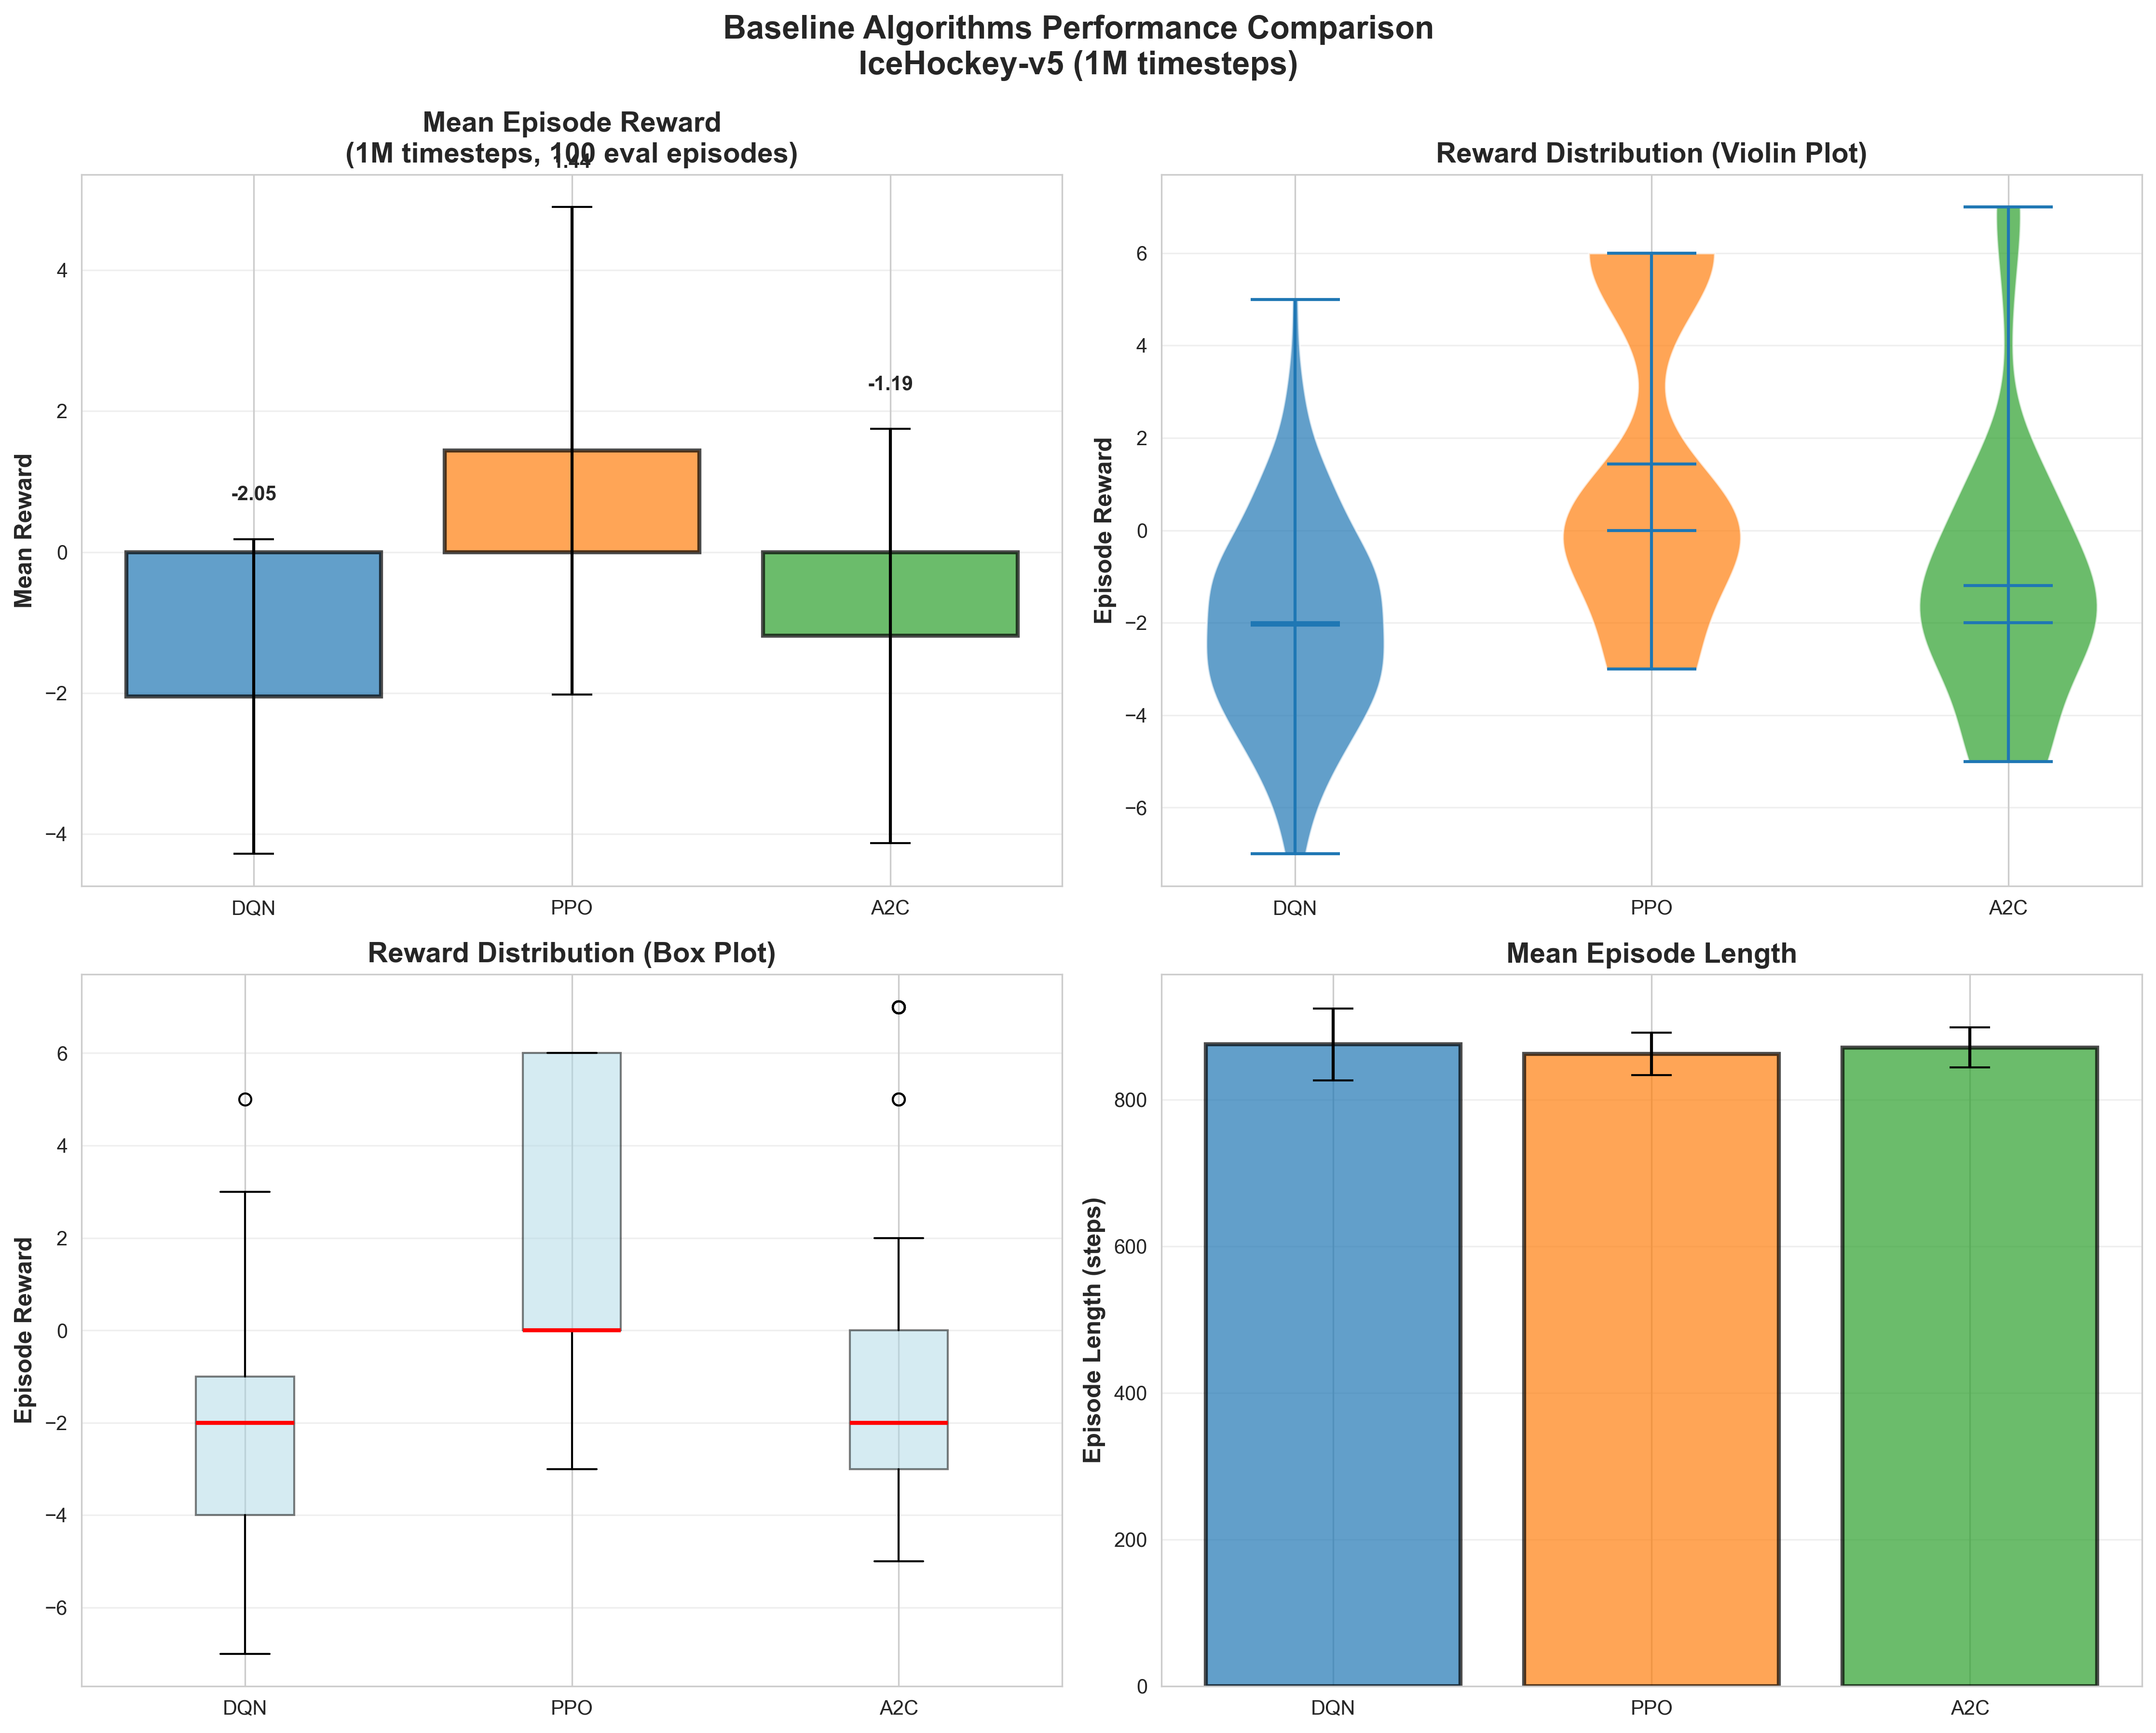


Reward Distributions:


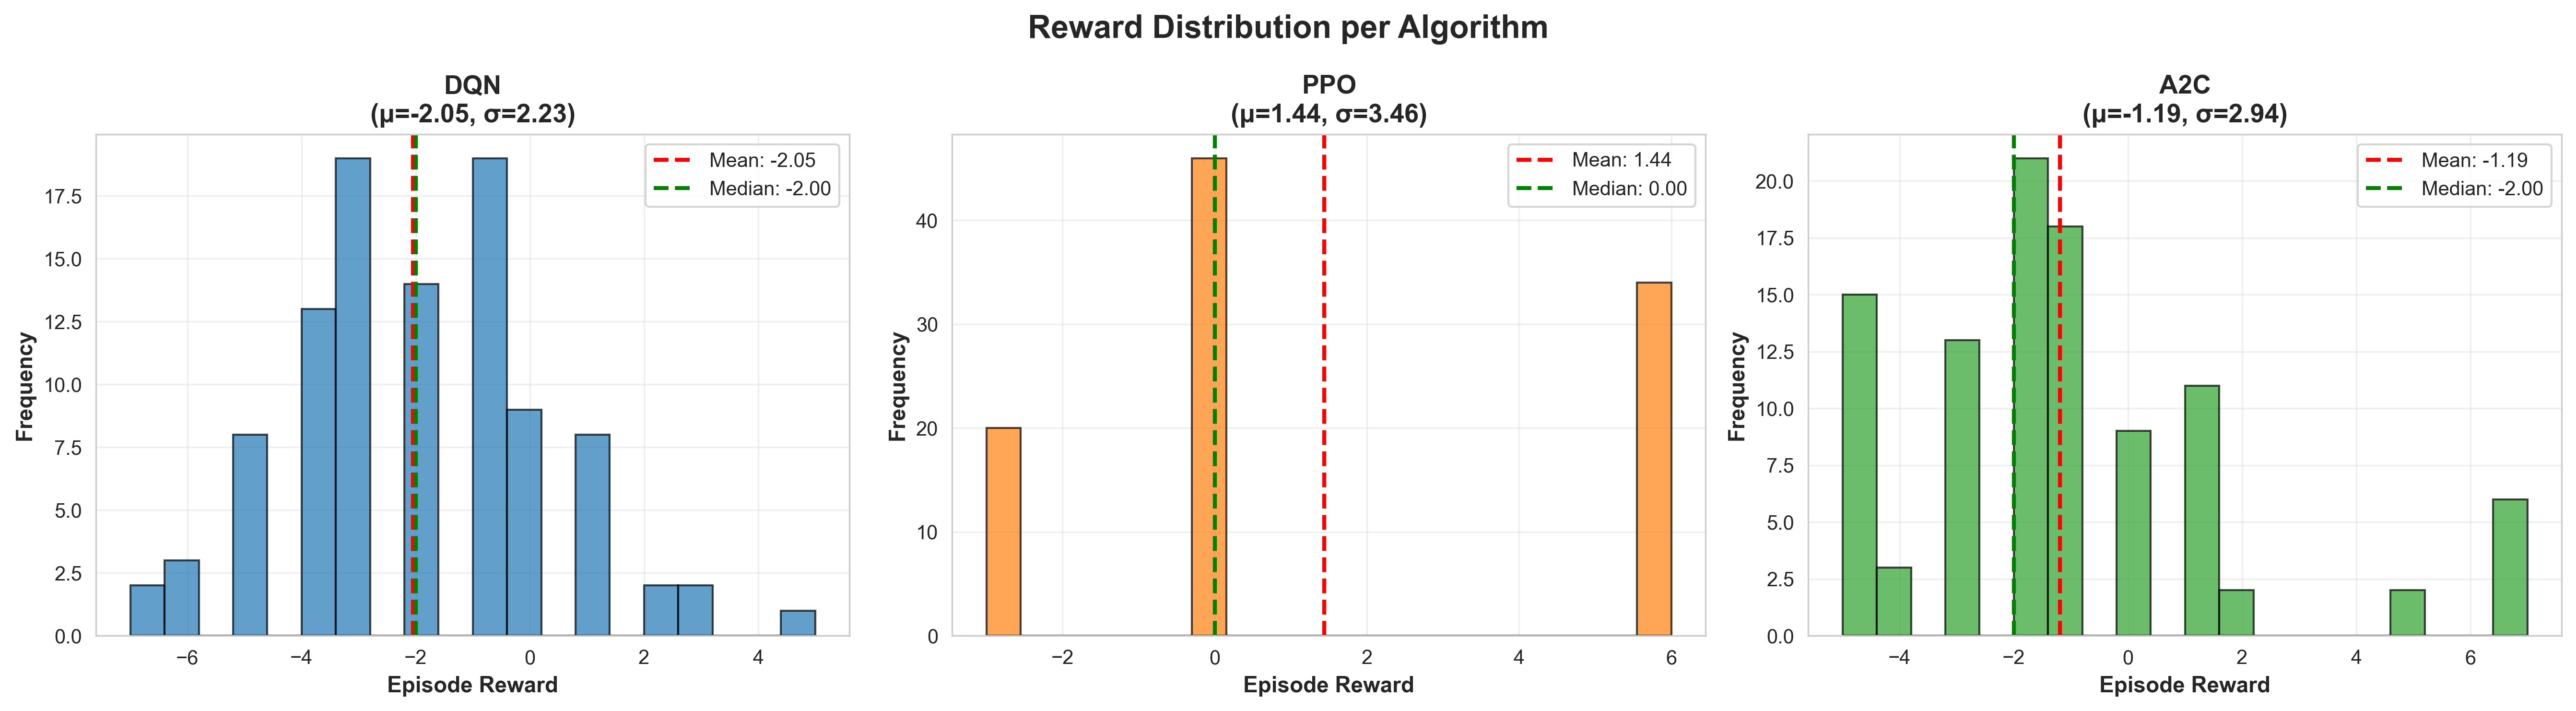


Learning Curves:


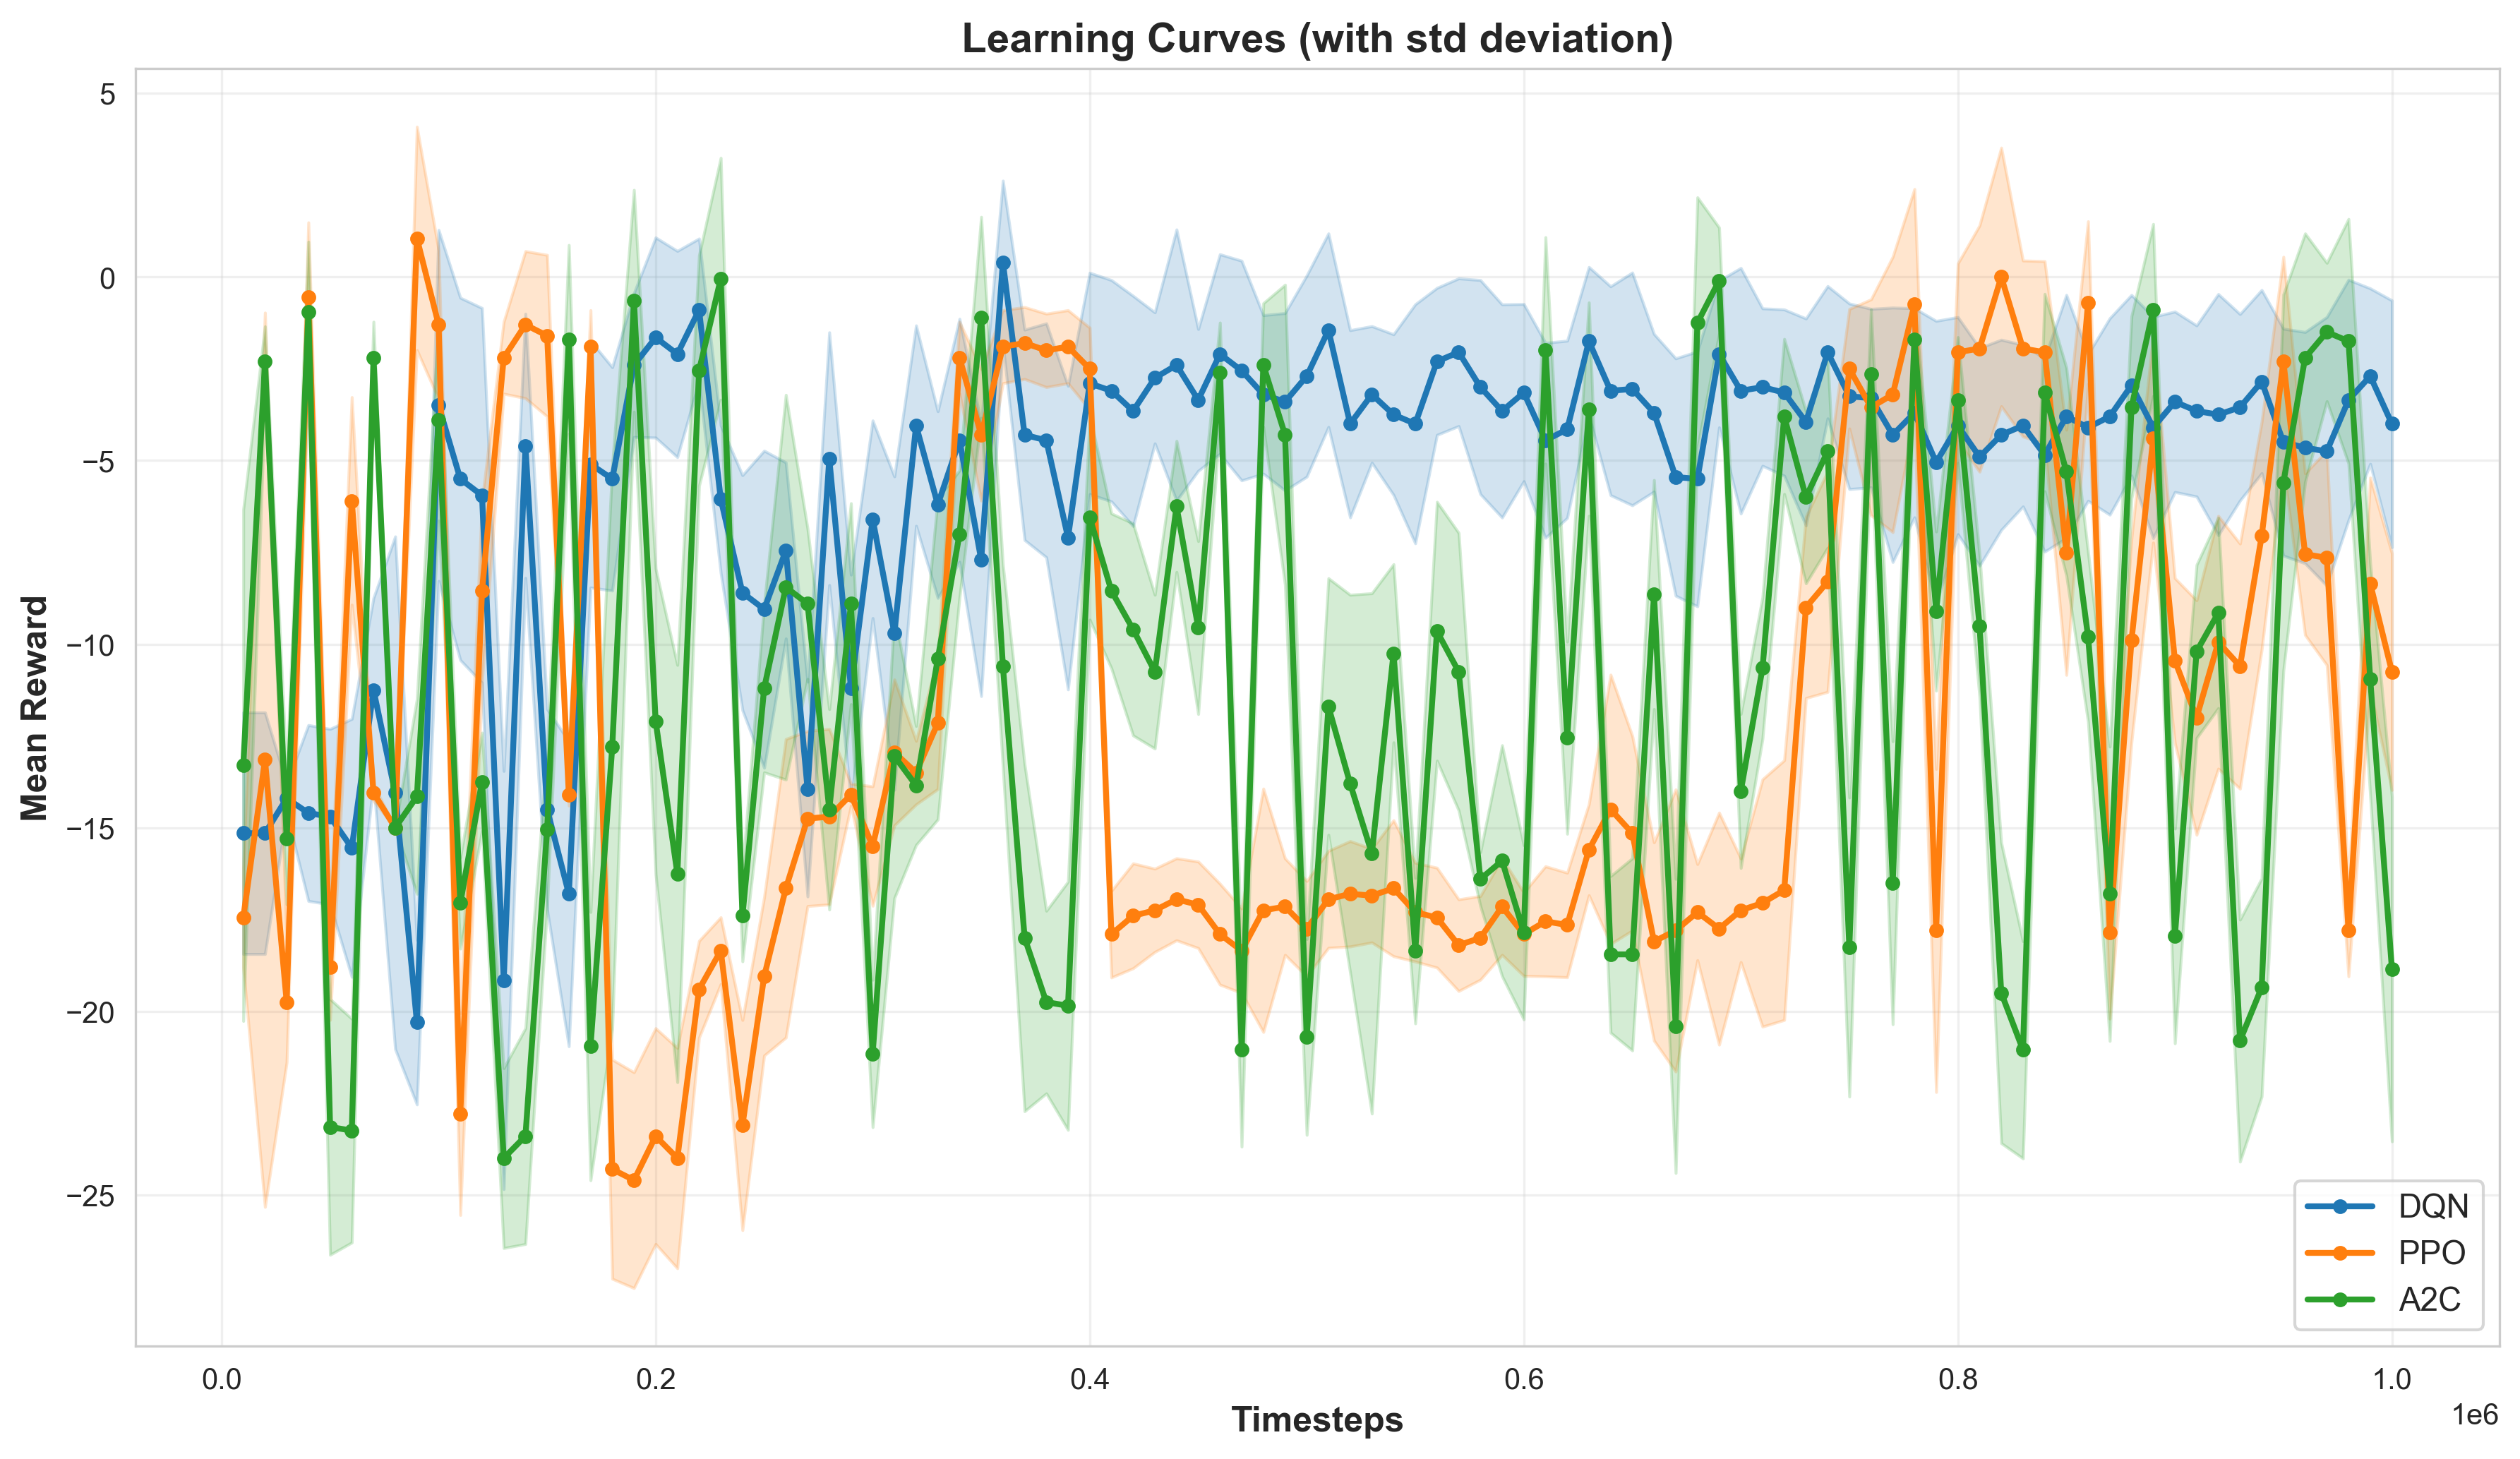

In [ ]:
print("\nPerformance Comparison:")
display(Image('baseline_1M/figures/baseline_performance.png'))

print("\nReward Distributions:")
display(Image('baseline_1M/figures/baseline_distributions.png'))

print("\nLearning Curves:")
display(Image('baseline_1M/figures/baseline_learning_curves.png'))

**Mean Episode Performance**

The average results obtained are as follows:
DQN:
Mean = −2.05 ± 2.23
PPO:
Mean = +1.44 ± 3.46
A2C:
Mean = −1.19 ± 2.94

PPO clearly achieves the best average performance, being the only algorithm to obtain a positive mean reward after training. This indicates that the PPO-trained agent is able, on average, to score more goals than it concedes, whereas DQN and A2C remain below zero performance.
DQN exhibits the weakest performance, suggesting significant difficulties in learning an effective policy in this complex, visually rich environment. A2C achieves intermediate results, outperforming DQN but still failing to reach consistently positive outcomes.

**Reward Distribution Analysis**

The reward distributions (violin plots, box plots, and histograms) highlight substantial behavioral differences among the algorithms:

DQN
Rewards are heavily concentrated in negative values
Median reward = −2.0
Few episodes with positive returns
High frequency of poor-performing episodes
These results indicate that DQN struggles to learn effective behaviors, likely due to the combination of high-dimensional visual inputs, sparse rewards, and environmental complexity.

PPO
Broader distribution including high positive rewards
Median reward = 0.0
Upper quartile (Q75) = 6.0
Higher variance but many successful episodes
Although PPO exhibits a higher standard deviation, this variability reflects the presence of strongly positive episodes, suggesting that PPO learns effective offensive strategies, albeit with some inconsistency.

A2C
Distribution centered around moderately negative values
Median reward = −2.0
Fewer highly positive episodes compared to PPO
A2C demonstrates some learning capability but does not achieve the level of performance or consistency observed with PPO.

**Average Episode Length**

All three algorithms show similar average episode lengths:
DQN: ~875 steps
PPO: ~862 steps
A2C: ~871 steps
This suggests that none of the agents consistently learn strategies that significantly shorten episodes, such as rapid victories or early collapses. Therefore, the observed performance differences are primarily driven by decision quality during gameplay, rather than episode duration.

**Learning Curves**

The learning curves reveal distinct training behaviors:

DQN shows slow and unstable learning, with only marginal improvements over time.
A2C displays some initial progress but with high variance and no clear convergence.
PPO demonstrates a more consistent upward trend throughout training, despite the inherent stochasticity of the environment.

These observations further support the suitability of policy-gradient methods, such as PPO, for complex and dynamic environments like IceHockey.

**Overall Comparison and Best Baseline**

Considering all evaluation metrics — mean reward, distribution shape, stability, and learning curves — PPO emerges as the strongest baseline:
- Only algorithm with positive mean reward
- Highest frequency of successful episodes
- Better adaptation to environmental complexity

DQN proves to be the least suitable method for this task, while A2C provides an intermediate trade-off between training speed and performance.

***
## 5. Custom Environment Agent

In [ ]:
"""
CUSTOM ENVIRONMENT TRAINING - 1M TIMESTEPS
Uses CustomIceHockeyEnv with reward engineering
"""

class CustomConfig:
    """Configuration for custom environment training"""
    
    # Environment
    ENV_ID = 'ALE/IceHockey-v5'
    N_STACK = 4
    
    # Training
    TOTAL_TIMESTEPS = 1_000_000  # 1M per algorithm
    EVAL_FREQ = 10_000
    N_EVAL_EPISODES = 20
    SAVE_FREQ = 50_000
    DEVICE = 'cuda'
    
    # Directories
    BASE_DIR = 'custom_1M/'
    MODELS_DIR = BASE_DIR + 'models/'
    LOGS_DIR = BASE_DIR + 'logs/'
    RESULTS_DIR = BASE_DIR + 'results/'
    FIGURES_DIR = BASE_DIR + 'figures/'
    
    # Custom reward parameters (from your CustomIceHockeyEnv)
    REWARD_PARAMS = {
        'goal_scored_reward': 1.0,
        'goal_conceded_penalty': -1.0,
        'movement_bonus': 0.001,
        'fire_bonus': 0.002,
        'repetition_penalty_base': -0.001,
        'repetition_threshold': 5,
        'fire_window_penalty': -0.01,
        'fire_window_size': 30,
    }
    
    # Same algorithms as baseline (for fair comparison)
    ALGORITHMS = {
        'DQN': {
            'class': DQN,
            'policy': 'CnnPolicy',
            'hyperparams': {
                'learning_rate': 1e-4,
                'buffer_size': 100_000,
                'learning_starts': 50_000,
                'batch_size': 32,
                'tau': 1.0,
                'gamma': 0.99,
                'train_freq': 4,
                'gradient_steps': 1,
                'target_update_interval': 10_000,
                'exploration_fraction': 0.1,
                'exploration_initial_eps': 1.0,
                'exploration_final_eps': 0.01,
                'verbose': 1,
            }
        },
        'PPO': {
            'class': PPO,
            'policy': 'CnnPolicy',
            'hyperparams': {
                'learning_rate': 2.5e-4,
                'n_steps': 128,
                'batch_size': 256,
                'n_epochs': 4,
                'gamma': 0.99,
                'gae_lambda': 0.95,
                'clip_range': 0.1,
                'clip_range_vf': None,
                'ent_coef': 0.01,
                'vf_coef': 0.5,
                'max_grad_norm': 0.5,
                'verbose': 1,
            }
        },
        'A2C': {
            'class': A2C,
            'policy': 'CnnPolicy',
            'hyperparams': {
                'learning_rate': 7e-4,
                'n_steps': 5,
                'gamma': 0.99,
                'gae_lambda': 1.0,
                'ent_coef': 0.01,
                'vf_coef': 0.5,
                'max_grad_norm': 0.5,
                'rms_prop_eps': 1e-5,
                'verbose': 1,
            }
        }
    }
    
    @classmethod
    def create_dirs(cls):
        """Create all necessary directories"""
        dirs = [cls.BASE_DIR, cls.MODELS_DIR, cls.LOGS_DIR, 
                cls.RESULTS_DIR, cls.FIGURES_DIR]
        
        for dir_path in dirs:
            os.makedirs(dir_path, exist_ok=True)
        
        for algo in cls.ALGORITHMS.keys():
            os.makedirs(os.path.join(cls.MODELS_DIR, algo.lower()), exist_ok=True)
            os.makedirs(os.path.join(cls.LOGS_DIR, algo.lower()), exist_ok=True)
            os.makedirs(os.path.join(cls.RESULTS_DIR, algo.lower()), exist_ok=True)
        
        # Save reward parameters
        with open(os.path.join(cls.BASE_DIR, 'reward_parameters.json'), 'w') as f:
            json.dump(cls.REWARD_PARAMS, f, indent=2)

In [42]:
def make_custom_env():
    """Create single custom IceHockey environment"""
    env = gym.make(CustomConfig.ENV_ID)
    env = AtariWrapper(env)
    env = CustomRewardWrapper(
        env,
        **CustomConfig.REWARD_PARAMS
    )
    return env


def make_custom_vec_env():
    """Create vectorized + frame stacked custom environment"""
    env = DummyVecEnv([make_custom_env])
    env = VecFrameStack(env, n_stack=CustomConfig.N_STACK)
    return env

In [43]:
def train_custom_algorithm(algo_name: str, config: CustomConfig = CustomConfig) -> Dict:
    """
    Train a single algorithm on CUSTOM environment for 1M timesteps
    
    Args:
        algo_name: 'DQN', 'PPO', or 'A2C'
        config: Configuration object
    
    Returns:
        Dictionary with training results
    """
    print("\n" + "="*80)
    print(f"TRAINING {algo_name} ON CUSTOM ENVIRONMENT - 1,000,000 TIMESTEPS")
    print("="*80 + "\n")
    
    # Get algorithm configuration
    algo_config = config.ALGORITHMS[algo_name]
    AlgoClass = algo_config['class']
    
    print(f"Algorithm: {algo_name}")
    print(f"Environment: CUSTOM IceHockey (with reward engineering)")
    print(f"Total timesteps: {config.TOTAL_TIMESTEPS:,}")
    
    print(f"\nReward Engineering Parameters:")
    for key, value in config.REWARD_PARAMS.items():
        print(f"  {key:30s}: {value}")
    
    print(f"\nHyperparameters:")
    for key, value in algo_config['hyperparams'].items():
        print(f"  {key:25s}: {value}")
    
    # Create environments
    print("\nCreating custom environments...")
    train_env = make_custom_vec_env()
    eval_env = make_custom_vec_env()
    
    # Setup callbacks
    eval_callback = EvalCallback(
        eval_env=eval_env,
        best_model_save_path=os.path.join(config.MODELS_DIR, algo_name.lower()),
        log_path=os.path.join(config.LOGS_DIR, algo_name.lower()),
        eval_freq=config.EVAL_FREQ,
        n_eval_episodes=config.N_EVAL_EPISODES,
        deterministic=True,
        render=False,
        verbose=1
    )
    
    checkpoint_callback = CheckpointCallback(
        save_freq=config.SAVE_FREQ,
        save_path=os.path.join(config.MODELS_DIR, algo_name.lower()),
        name_prefix=f'{algo_name.lower()}_custom_checkpoint',
        verbose=1
    )
    
    callback = CallbackList([eval_callback, checkpoint_callback])
    
    # Create model
    print(f"\nCreating {algo_name} model...")
    model = AlgoClass(
        policy=algo_config['policy'],
        env=train_env,
        tensorboard_log=os.path.join(config.LOGS_DIR, algo_name.lower()),
        device=config.DEVICE,
        **algo_config['hyperparams']
    )
    
    # Train
    print(f"\n{'='*80}")
    print(f"STARTING TRAINING")
    print(f"{'='*80}\n")
    print(f"Start time: {time.strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"\nProgress will be saved every {config.SAVE_FREQ:,} steps")
    
    start_time = time.time()
    
    try:
        model.learn(
            total_timesteps=config.TOTAL_TIMESTEPS,
            callback=callback,
            progress_bar=True,
            log_interval=10
        )
        
        completed = True
        
    except KeyboardInterrupt:
        print("\n\nTRAINING INTERRUPTED BY USER")
        print("Progress has been saved.")
        completed = False
    
    except Exception as e:
        print(f"\n\nERROR DURING TRAINING: {e}")
        import traceback
        traceback.print_exc()
        completed = False
    
    end_time = time.time()
    training_time = end_time - start_time
    
    # Save final model
    final_model_path = os.path.join(
        config.MODELS_DIR,
        algo_name.lower(),
        f'{algo_name.lower()}_custom_final_1M.zip'
    )
    model.save(final_model_path)
    
    # Compile results
    results = {
        'algorithm': algo_name,
        'environment': 'custom',
        'completed': completed,
        'total_timesteps': config.TOTAL_TIMESTEPS,
        'training_time_seconds': training_time,
        'training_time_hours': training_time / 3600,
        'timesteps_per_second': config.TOTAL_TIMESTEPS / training_time,
        'reward_params': config.REWARD_PARAMS,
        'final_model_path': final_model_path,
        'best_model_path': os.path.join(config.MODELS_DIR, algo_name.lower(), 'best_model.zip'),
        'timestamp': time.strftime('%Y-%m-%d %H:%M:%S'),
    }
    
    # Save training info
    with open(os.path.join(config.RESULTS_DIR, algo_name.lower(), 'training_info.json'), 'w') as f:
        json.dump(results, f, indent=2)
    
    # Print summary
    print(f"\n{'='*80}")
    print(f"TRAINING {'COMPLETE' if completed else 'STOPPED'}")
    print(f"{'='*80}\n")
    print(f"Algorithm: {algo_name}")
    print(f"Environment: Custom (with reward engineering)")
    print(f"Timesteps: {config.TOTAL_TIMESTEPS:,}")
    print(f"Training time: {training_time/3600:.2f} hours ({training_time:.0f} seconds)")
    print(f"Speed: {results['timesteps_per_second']:.2f} timesteps/second")
    print(f"Final model saved: {final_model_path}")
    print(f"Best model saved: {results['best_model_path']}")
    
    train_env.close()
    eval_env.close()
    
    return results


def train_all_custom_algorithms(config: CustomConfig = CustomConfig) -> Dict[str, Dict]:
    """
    Train all algorithms on custom environment
    
    Returns:
        Dictionary with results for each algorithm
    """
    config.create_dirs()
    
    print("CUSTOM ENVIRONMENT TRAINING - ALL ALGORITHMS (1M TIMESTEPS EACH)")
    print("\n")
    
    print("Configuration:")
    print(f"  Base Environment: {config.ENV_ID}")
    print(f"  Custom Rewards: ENABLED")
    print(f"  Timesteps per algorithm: {config.TOTAL_TIMESTEPS:,}")
    print(f"  Algorithms: {list(config.ALGORITHMS.keys())}")
    print(f"  Frame stack: {config.N_STACK}")
    print(f"  Device: {config.DEVICE}")
    
    print(f"\nReward Engineering:")
    for key, value in config.REWARD_PARAMS.items():
        print(f"  {key}: {value}")
    
    print(f"\nResults saved to: {config.BASE_DIR}")
    print("\n" + "="*80)
    
    input("\nPress Enter to start training (or Ctrl+C to cancel)...")
    
    all_results = {}
    training_order = list(config.ALGORITHMS.keys())
    
    for i, algo_name in enumerate(training_order, 1):
        print(f"\n\n{'='*80}")
        print(f"ALGORITHM {i}/{len(training_order)}: {algo_name}")
        print(f"{'='*80}\n")
        
        try:
            results = train_custom_algorithm(algo_name, config)
            all_results[algo_name] = results
            
            print(f"\n{algo_name} training complete!")
            
            # Show progress
            completed = sum(1 for r in all_results.values() if r['completed'])
            print(f"\nProgress: {completed}/{len(training_order)} algorithms completed")
            
            if i < len(training_order):
                print(f"\nNext: {training_order[i]}")
                time.sleep(2)
                
        except KeyboardInterrupt:
            print(f"\n\nTraining suite interrupted!")
            print(f"Completed algorithms: {list(all_results.keys())}")
            break
        
        except Exception as e:
            print(f"\nError training {algo_name}: {e}")
            import traceback
            traceback.print_exc()
            continue
    
    # Final summary
    print("\n\n" + "="*80)
    print("CUSTOM TRAINING SUITE COMPLETE")
    print("="*80 + "\n")
    
    print("Results summary:")
    for algo_name, results in all_results.items():
        status = "COMPLETE" if results['completed'] else "INCOMPLETE"
        print(f"\n{algo_name}: {status}")
        print(f"  Training time: {results['training_time_hours']:.2f} hours")
        print(f"  Speed: {results['timesteps_per_second']:.2f} timesteps/sec")
        print(f"  Model: {results['best_model_path']}")
    
    # Save summary
    summary_path = os.path.join(config.RESULTS_DIR, 'training_summary.json')
    with open(summary_path, 'w') as f:
        json.dump(all_results, f, indent=2)
    
    print(f"\nSummary saved to: {summary_path}")
    
    print("\n" + "="*80)
    print("Next steps:")
    print("  1. Evaluate custom models: evaluate_all_custom()")
    print("  2. Compare with baseline (Section 6)")
    print("="*80 + "\n")
    
    return all_results


In [44]:
def evaluate_custom_model(algo_name: str, n_episodes: int = 100, 
                         config: CustomConfig = CustomConfig) -> Dict:
    """
    Evaluate a trained custom environment model
    
    Args:
        algo_name: Algorithm name
        n_episodes: Number of evaluation episodes
        config: Configuration object
    
    Returns:
        Evaluation results dictionary with custom stats
    """
    print(f"\n{'='*80}")
    print(f"EVALUATING {algo_name} ON CUSTOM ENV (n={n_episodes} episodes)")
    print(f"{'='*80}\n")
    
    # Load model
    model_path = os.path.join(config.MODELS_DIR, algo_name.lower(), 'best_model.zip')
    
    if not os.path.exists(model_path):
        print(f"Model not found: {model_path}")
        return None
    
    AlgoClass = config.ALGORITHMS[algo_name]['class']
    print(f"Loading model from: {model_path}")
    model = AlgoClass.load(model_path)
    
    # Create eval environment
    eval_env = make_custom_vec_env()
    
    # Evaluate
    print(f"Running {n_episodes} evaluation episodes...")
    start_time = time.time()
    
    episode_rewards = []
    episode_lengths = []
    episode_original_rewards = []
    episode_modified_rewards = []
    
    # Custom stats
    goals_scored_list = []
    goals_conceded_list = []
    movement_bonuses_list = []
    fire_bonuses_list = []
    repetition_penalties_list = []
    fire_window_penalties_list = []
    
    for ep in range(n_episodes):
        obs = eval_env.reset()
        done = False
        episode_length = 0
        
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, info = eval_env.step(action)
            episode_length += 1
        
        # Extract custom stats from final info
        if len(info) > 0 and 'episode_stats' in info[0]:
            stats = info[0]['episode_stats']
            episode_original_rewards.append(stats['total_original_reward'])
            episode_modified_rewards.append(stats['total_modified_reward'])
            goals_scored_list.append(stats['goals_scored'])
            goals_conceded_list.append(stats['goals_conceded'])
            movement_bonuses_list.append(stats['movement_bonuses'])
            fire_bonuses_list.append(stats['fire_bonuses'])
            repetition_penalties_list.append(stats['repetition_penalties'])
            fire_window_penalties_list.append(stats['fire_window_penalties'])
        
        episode_rewards.append(reward[0])
        episode_lengths.append(episode_length)
        
        if (ep + 1) % 20 == 0:
            print(f"  Progress: {ep + 1}/{n_episodes} episodes...")
    
    eval_time = time.time() - start_time
    eval_env.close()
    
    # Compile results
    results = {
        'algorithm': algo_name,
        'environment': 'custom',
        'n_episodes': n_episodes,
        'mean_reward': float(np.mean(episode_rewards)),
        'std_reward': float(np.std(episode_rewards)),
        'min_reward': float(np.min(episode_rewards)),
        'max_reward': float(np.max(episode_rewards)),
        'median_reward': float(np.median(episode_rewards)),
        'q25_reward': float(np.percentile(episode_rewards, 25)),
        'q75_reward': float(np.percentile(episode_rewards, 75)),
        'mean_length': float(np.mean(episode_lengths)),
        'std_length': float(np.std(episode_lengths)),
        'eval_time_seconds': eval_time,
        
        # Custom environment specific stats
        'custom_stats': {
            'mean_original_reward': float(np.mean(episode_original_rewards)) if episode_original_rewards else None,
            'mean_modified_reward': float(np.mean(episode_modified_rewards)) if episode_modified_rewards else None,
            'reward_delta': float(np.mean(episode_modified_rewards) - np.mean(episode_original_rewards)) if episode_modified_rewards else None,
            'mean_goals_scored': float(np.mean(goals_scored_list)) if goals_scored_list else None,
            'mean_goals_conceded': float(np.mean(goals_conceded_list)) if goals_conceded_list else None,
            'mean_movement_bonuses': float(np.mean(movement_bonuses_list)) if movement_bonuses_list else None,
            'mean_fire_bonuses': float(np.mean(fire_bonuses_list)) if fire_bonuses_list else None,
            'mean_repetition_penalties': float(np.mean(repetition_penalties_list)) if repetition_penalties_list else None,
            'mean_fire_window_penalties': float(np.mean(fire_window_penalties_list)) if fire_window_penalties_list else None,
        }
    }
    
    # Print results
    print(f"\nRESULTS:")
    print(f"  Mean Reward:   {results['mean_reward']:8.3f} ± {results['std_reward']:.3f}")
    print(f"  Median Reward: {results['median_reward']:8.3f}")
    print(f"  Min/Max:       [{results['min_reward']:6.1f}, {results['max_reward']:6.1f}]")
    print(f"  Mean Length:   {results['mean_length']:8.1f} ± {results['std_length']:.1f} steps")
    
    if results['custom_stats']['mean_original_reward'] is not None:
        print(f"\nCUSTOM ENVIRONMENT STATS:")
        print(f"  Original Reward:      {results['custom_stats']['mean_original_reward']:8.3f}")
        print(f"  Modified Reward:      {results['custom_stats']['mean_modified_reward']:8.3f}")
        print(f"  Reward Delta:         {results['custom_stats']['reward_delta']:+8.3f}")
        print(f"  Goals Scored:         {results['custom_stats']['mean_goals_scored']:8.2f}")
        print(f"  Goals Conceded:       {results['custom_stats']['mean_goals_conceded']:8.2f}")
        print(f"  Movement Bonuses:     {results['custom_stats']['mean_movement_bonuses']:8.1f}")
        print(f"  Fire Bonuses:         {results['custom_stats']['mean_fire_bonuses']:8.1f}")
        print(f"  Repetition Penalties: {results['custom_stats']['mean_repetition_penalties']:8.1f}")
        print(f"  Fire Window Penalties:{results['custom_stats']['mean_fire_window_penalties']:8.1f}")
    
    print(f"  Eval time:            {eval_time:8.2f} seconds")
    
    # Save results
    results_path = os.path.join(config.RESULTS_DIR, algo_name.lower(), 'evaluation_results.json')
    with open(results_path, 'w') as f:
        json.dump(results, f, indent=2)
    
    # Save detailed data
    np.save(
        os.path.join(config.RESULTS_DIR, algo_name.lower(), 'episode_rewards.npy'),
        episode_rewards
    )
    np.save(
        os.path.join(config.RESULTS_DIR, algo_name.lower(), 'episode_lengths.npy'),
        episode_lengths
    )
    
    if episode_original_rewards:
        np.save(
            os.path.join(config.RESULTS_DIR, algo_name.lower(), 'episode_original_rewards.npy'),
            episode_original_rewards
        )
        np.save(
            os.path.join(config.RESULTS_DIR, algo_name.lower(), 'episode_modified_rewards.npy'),
            episode_modified_rewards
        )
    
    print(f"\nResults saved to: {config.RESULTS_DIR}{algo_name.lower()}/")
    
    return results


def evaluate_all_custom(n_episodes: int = 100, config: CustomConfig = CustomConfig) -> Dict[str, Dict]:
    """
    Evaluate all trained custom models
    
    Returns:
        Dictionary with evaluation results for each algorithm
    """
    print("CUSTOM ENVIRONMENT EVALUATION - ALL ALGORITHMS")
    
    all_results = {}
    
    for algo_name in config.ALGORITHMS.keys():
        try:
            results = evaluate_custom_model(algo_name, n_episodes, config)
            if results:
                all_results[algo_name] = results
        except Exception as e:
            print(f"\nError evaluating {algo_name}: {e}")
            import traceback
            traceback.print_exc()
    
    if not all_results:
        print("\nNo results to compare")
        return {}
    
    # Print comparison
    print("\n" + "="*80)
    print("CUSTOM ENVIRONMENT COMPARISON TABLE")
    print("="*80 + "\n")
    
    # Create comparison DataFrame
    comparison_data = []
    for algo, res in all_results.items():
        row = {
            'Algorithm': algo,
            'Mean Reward': f"{res['mean_reward']:.3f}",
            'Std': f"{res['std_reward']:.3f}",
            'Median': f"{res['median_reward']:.3f}",
        }
        
        if res['custom_stats']['mean_goals_scored']:
            row['Goals Scored'] = f"{res['custom_stats']['mean_goals_scored']:.2f}"
            row['Goals Conceded'] = f"{res['custom_stats']['mean_goals_conceded']:.2f}"
            row['Reward Delta'] = f"{res['custom_stats']['reward_delta']:+.3f}"
        
        comparison_data.append(row)
    
    df = pd.DataFrame(comparison_data)
    print(df.to_string(index=False))
    
    # Identify best
    best_algo = max(all_results.items(), key=lambda x: x[1]['mean_reward'])
    print(f"\nBEST ON CUSTOM ENVIRONMENT: {best_algo[0]}")
    print(f"   Mean Reward: {best_algo[1]['mean_reward']:.3f} ± {best_algo[1]['std_reward']:.3f}")
    
    # Save comparison
    df.to_csv(os.path.join(config.RESULTS_DIR, 'custom_comparison.csv'), index=False)
    
    with open(os.path.join(config.RESULTS_DIR, 'evaluation_summary.json'), 'w') as f:
        json.dump(all_results, f, indent=2)
    
    print(f"\nComparison saved to: {config.RESULTS_DIR}")
    
    return all_results

In [60]:
def create_custom_visualizations(config: CustomConfig = CustomConfig):
    """Generate comprehensive visualizations of custom environment results"""
    
    print("\nGENERATING CUSTOM ENVIRONMENT VISUALIZATIONS\n")
    
    # Load evaluation results
    results = {}
    for algo_name in config.ALGORITHMS.keys():
        results_path = os.path.join(
            config.RESULTS_DIR,
            algo_name.lower(),
            'evaluation_results.json'
        )
        
        if os.path.exists(results_path):
            with open(results_path, 'r') as f:
                results[algo_name] = json.load(f)
            
            # Load episode rewards
            rewards_path = os.path.join(
                config.RESULTS_DIR,
                algo_name.lower(),
                'episode_rewards.npy'
            )
            if os.path.exists(rewards_path):
                results[algo_name]['episode_rewards'] = np.load(rewards_path)
    
    if not results:
        print("No results found to visualize")
        return
    
    sns.set_style("whitegrid")
    algorithms = list(results.keys())
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
    # ==========================================
    # Figure 1: Performance Comparison
    # ==========================================
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1.1: Bar chart - Mean rewards
    means = [results[algo]['mean_reward'] for algo in algorithms]
    stds = [results[algo]['std_reward'] for algo in algorithms]
    
    axes[0, 0].bar(algorithms, means, yerr=stds, capsize=10,
                   color=colors[:len(algorithms)], alpha=0.7, edgecolor='black', linewidth=2)
    axes[0, 0].set_ylabel('Mean Reward', fontsize=12, fontweight='bold')
    axes[0, 0].set_title('Mean Episode Reward\n(1M timesteps, 100 eval episodes)', 
                         fontsize=14, fontweight='bold')
    axes[0, 0].grid(alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, (mean, std) in enumerate(zip(means, stds)):
        axes[0, 0].text(i, mean + std + 0.5, f'{mean:.2f}',
                       ha='center', va='bottom', fontweight='bold')
    
    # 1.2: Violin plot
    violin_data = [results[algo]['episode_rewards'] for algo in algorithms]
    parts = axes[0, 1].violinplot(violin_data, positions=range(len(algorithms)),
                                   showmeans=True, showmedians=True)
    
    for i, pc in enumerate(parts['bodies']):
        pc.set_facecolor(colors[i])
        pc.set_alpha(0.7)
    
    axes[0, 1].set_xticks(range(len(algorithms)))
    axes[0, 1].set_xticklabels(algorithms)
    axes[0, 1].set_ylabel('Episode Reward', fontsize=12, fontweight='bold')
    axes[0, 1].set_title('Reward Distribution (Violin Plot)', fontsize=14, fontweight='bold')
    axes[0, 1].grid(alpha=0.3, axis='y')
    
    # 1.3: Box plot
    axes[1, 0].boxplot(violin_data, labels=algorithms, patch_artist=True,
                       boxprops=dict(facecolor='lightblue', alpha=0.5),
                       medianprops=dict(color='red', linewidth=2))
    axes[1, 0].set_ylabel('Episode Reward', fontsize=12, fontweight='bold')
    axes[1, 0].set_title('Reward Distribution (Box Plot)', fontsize=14, fontweight='bold')
    axes[1, 0].grid(alpha=0.3, axis='y')
    
    # 1.4: Episode lengths
    lengths = [results[algo]['mean_length'] for algo in algorithms]
    length_stds = [results[algo]['std_length'] for algo in algorithms]
    
    axes[1, 1].bar(algorithms, lengths, yerr=length_stds, capsize=10,
                   color=colors[:len(algorithms)], alpha=0.7, edgecolor='black', linewidth=2)
    axes[1, 1].set_ylabel('Episode Length (steps)', fontsize=12, fontweight='bold')
    axes[1, 1].set_title('Mean Episode Length', fontsize=14, fontweight='bold')
    axes[1, 1].grid(alpha=0.3, axis='y')
    
    fig.suptitle('Custom Environment - Algorithms Performance Comparison\nIceHockey-v5 (1M timesteps)', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    plt.savefig(os.path.join(config.FIGURES_DIR, 'custom_performance.png'), dpi=300)
    print("Saved: custom_performance.png")
    plt.close()
    
    # ==========================================
    # Figure 2: Detailed distributions 
    # ==========================================
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    for i, algo in enumerate(algorithms):
        axes[i].hist(results[algo]['episode_rewards'], bins=20, 
                    color=colors[i], alpha=0.7, edgecolor='black')
        axes[i].axvline(results[algo]['mean_reward'], color='red', 
                       linestyle='--', linewidth=2, label=f"Mean: {results[algo]['mean_reward']:.2f}")
        axes[i].axvline(results[algo]['median_reward'], color='green',
                       linestyle='--', linewidth=2, label=f"Median: {results[algo]['median_reward']:.2f}")
        axes[i].set_xlabel('Episode Reward', fontsize=11, fontweight='bold')
        axes[i].set_ylabel('Frequency', fontsize=11, fontweight='bold')
        axes[i].set_title(f'{algo}\n(μ={results[algo]["mean_reward"]:.2f}, σ={results[algo]["std_reward"]:.2f})',
                         fontsize=13, fontweight='bold')
        axes[i].legend()
        axes[i].grid(alpha=0.3)
    
    plt.suptitle('Reward Distribution per Algorithm', fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(os.path.join(config.FIGURES_DIR, 'custom_distributions.png'),
                dpi=300, bbox_inches='tight')
    print("Saved: custom_distributions.png")
    plt.close()
    
    # ==========================================
    # Figure 3: Learning curves 
    # ==========================================
    fig, ax = plt.subplots(1, 1, figsize=(12, 7))
    
    found_curves = False
    for i, algo in enumerate(algorithms):
        # Try to load from evaluation callback
        eval_log_path = os.path.join(
            config.LOGS_DIR,
            algo.lower(),
            'evaluations.npz'
        )
        
        if os.path.exists(eval_log_path):
            data = np.load(eval_log_path)
            timesteps = data['timesteps']
            results_array = data['results']
            mean_rewards = np.mean(results_array, axis=1)
            std_rewards = np.std(results_array, axis=1)
            
            ax.plot(timesteps, mean_rewards, label=algo, color=colors[i], 
                   linewidth=2, marker='o', markersize=4)
            ax.fill_between(timesteps, 
                           mean_rewards - std_rewards,
                           mean_rewards + std_rewards,
                           alpha=0.2, color=colors[i])
            found_curves = True
    
    if found_curves:
        ax.set_xlabel('Timesteps', fontsize=12, fontweight='bold')
        ax.set_ylabel('Mean Reward', fontsize=12, fontweight='bold')
        ax.set_title('Learning Curves (with std deviation)',
                    fontsize=14, fontweight='bold')
        ax.legend(fontsize=11)
        ax.grid(alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(os.path.join(config.FIGURES_DIR, 'custom_learning_curves.png'),
                    dpi=300, bbox_inches='tight')
        print("Saved: custom_learning_curves.png")
    else:
        print("Learning curves not available")
    
    plt.close()
    
    print(f"\nAll visualizations saved to: {config.FIGURES_DIR}")

### 5.1 Training with custom rewards

In [ ]:
custom_training_results = train_all_custom_algorithms(CustomConfig)
custom_training_results

### 5.3 Results per configuration

In [47]:
custom_eval_summary = evaluate_all_custom(n_episodes=100, config=CustomConfig)
custom_eval_summary

CUSTOM ENVIRONMENT EVALUATION - ALL ALGORITHMS

EVALUATING DQN ON CUSTOM ENV (n=100 episodes)

Loading model from: custom_1M/models/dqn\best_model.zip
Running 100 evaluation episodes...
  Progress: 20/100 episodes...
  Progress: 40/100 episodes...
  Progress: 60/100 episodes...
  Progress: 80/100 episodes...
  Progress: 100/100 episodes...

RESULTS:
  Mean Reward:      0.001 ± 0.002
  Median Reward:    0.001
  Min/Max:       [  -0.0,    0.0]
  Mean Length:      830.9 ± 45.4 steps

CUSTOM ENVIRONMENT STATS:
  Original Reward:        -4.410
  Modified Reward:        -3.634
  Reward Delta:           +0.776
  Goals Scored:             5.78
  Goals Conceded:          10.19
  Movement Bonuses:        216.8
  Fire Bonuses:            489.6
  Repetition Penalties:    100.5
  Fire Window Penalties:     0.3
  Eval time:              342.10 seconds

Results saved to: custom_1M/results/dqn/

EVALUATING PPO ON CUSTOM ENV (n=100 episodes)

Loading model from: custom_1M/models/ppo\best_model.zip
Runn

{'DQN': {'algorithm': 'DQN',
  'environment': 'custom',
  'n_episodes': 100,
  'mean_reward': 0.0007500001229345798,
  'std_reward': 0.0015580437611788511,
  'min_reward': -0.00800000037997961,
  'max_reward': 0.0020000000949949026,
  'median_reward': 0.0010000000474974513,
  'q25_reward': 0.0,
  'q75_reward': 0.0020000000949949026,
  'mean_length': 830.89,
  'std_length': 45.37441900454484,
  'eval_time_seconds': 342.10032320022583,
  'custom_stats': {'mean_original_reward': -4.41,
   'mean_modified_reward': -3.634020000000033,
   'reward_delta': 0.7759799999999673,
   'mean_goals_scored': 5.78,
   'mean_goals_conceded': 10.19,
   'mean_movement_bonuses': 216.83,
   'mean_fire_bonuses': 489.57,
   'mean_repetition_penalties': 100.45,
   'mean_fire_window_penalties': 0.34}},
 'PPO': {'algorithm': 'PPO',
  'environment': 'custom',
  'n_episodes': 100,
  'mean_reward': -0.018789999186992645,
  'std_reward': 0.02650105580687523,
  'min_reward': -0.10700000077486038,
  'max_reward': 0.0020

### 5.4 Best model selection

This section presents the evaluation of DQN, PPO, and A2C trained for 1 million timesteps on the custom IceHockey-v5 environment, incorporating reward engineering. All models were evaluated over 100 independent episodes using the same protocol adopted for the baseline experiments.

In [61]:
create_custom_visualizations(CustomConfig)


GENERATING CUSTOM ENVIRONMENT VISUALIZATIONS



C:\Users\simao\AppData\Local\Temp\ipykernel_8556\3948094772.py:73: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 0].boxplot(violin_data, labels=algorithms, patch_artist=True,
C:\Users\simao\AppData\Local\Temp\ipykernel_8556\3948094772.py:92: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


Saved: custom_performance.png
Saved: custom_distributions.png
Saved: custom_learning_curves.png

All visualizations saved to: custom_1M/figures/



Custom Environment Performance:


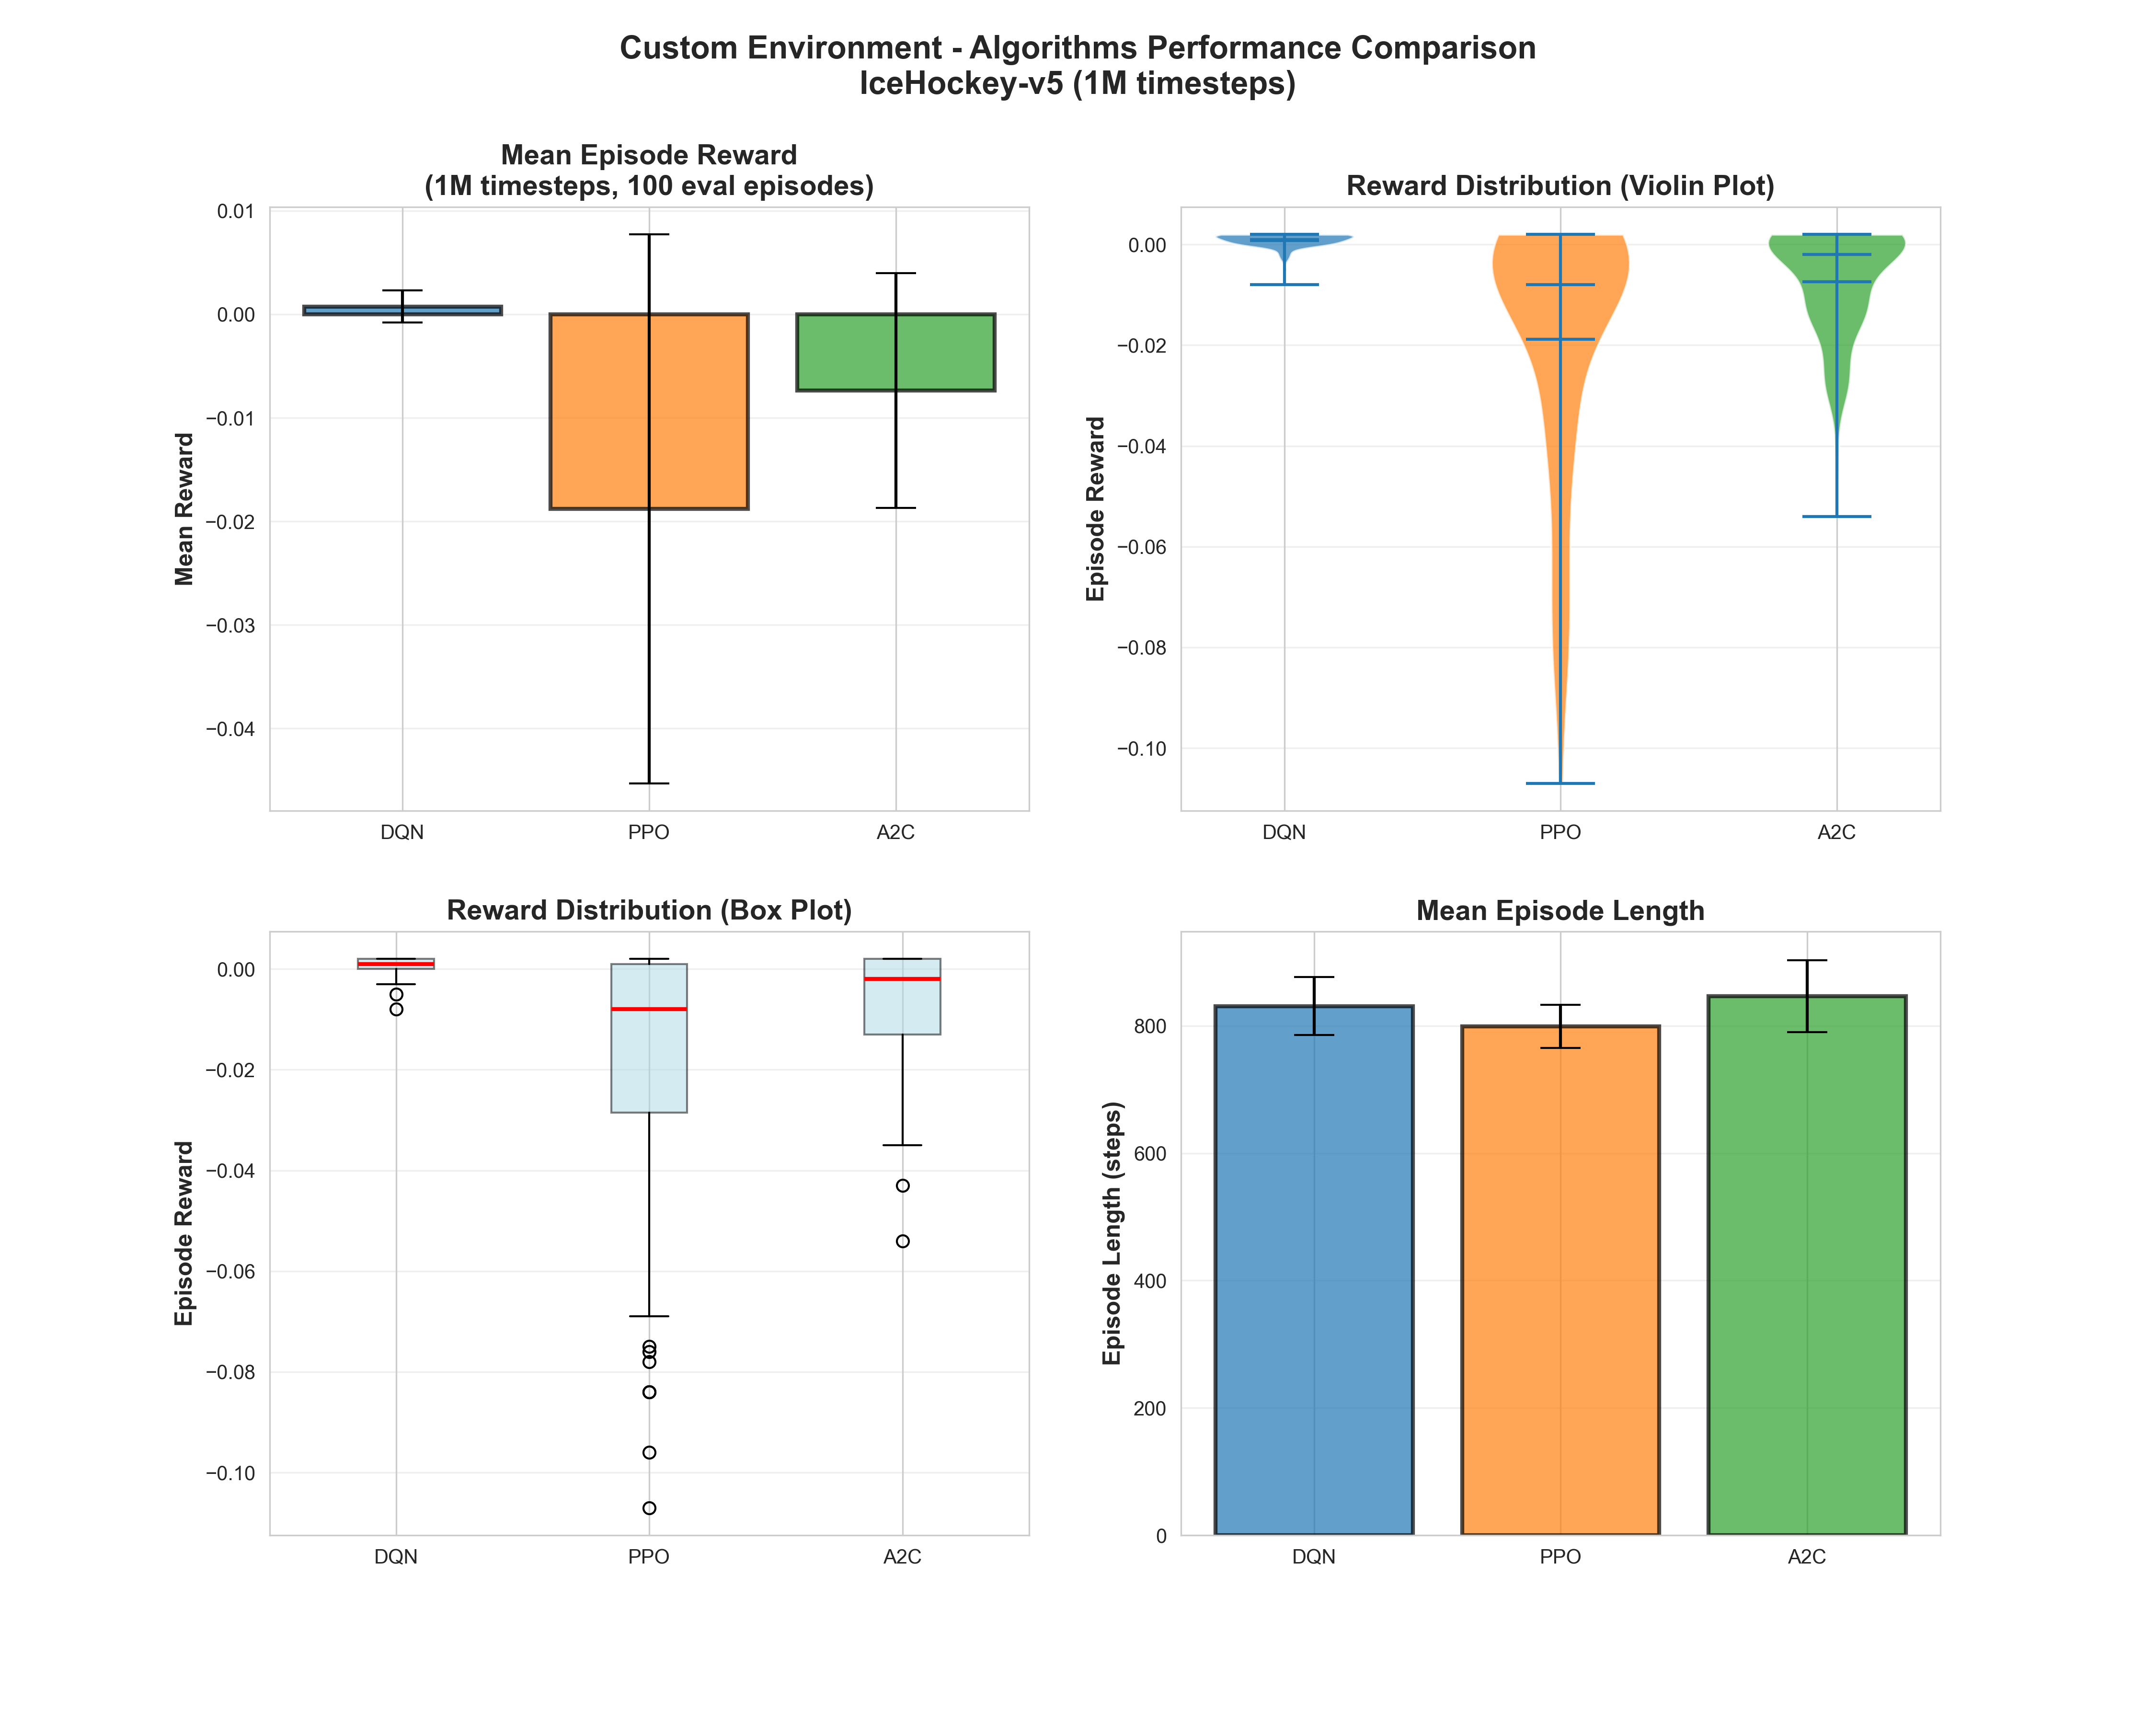


Custom Environment Reward Distributions:


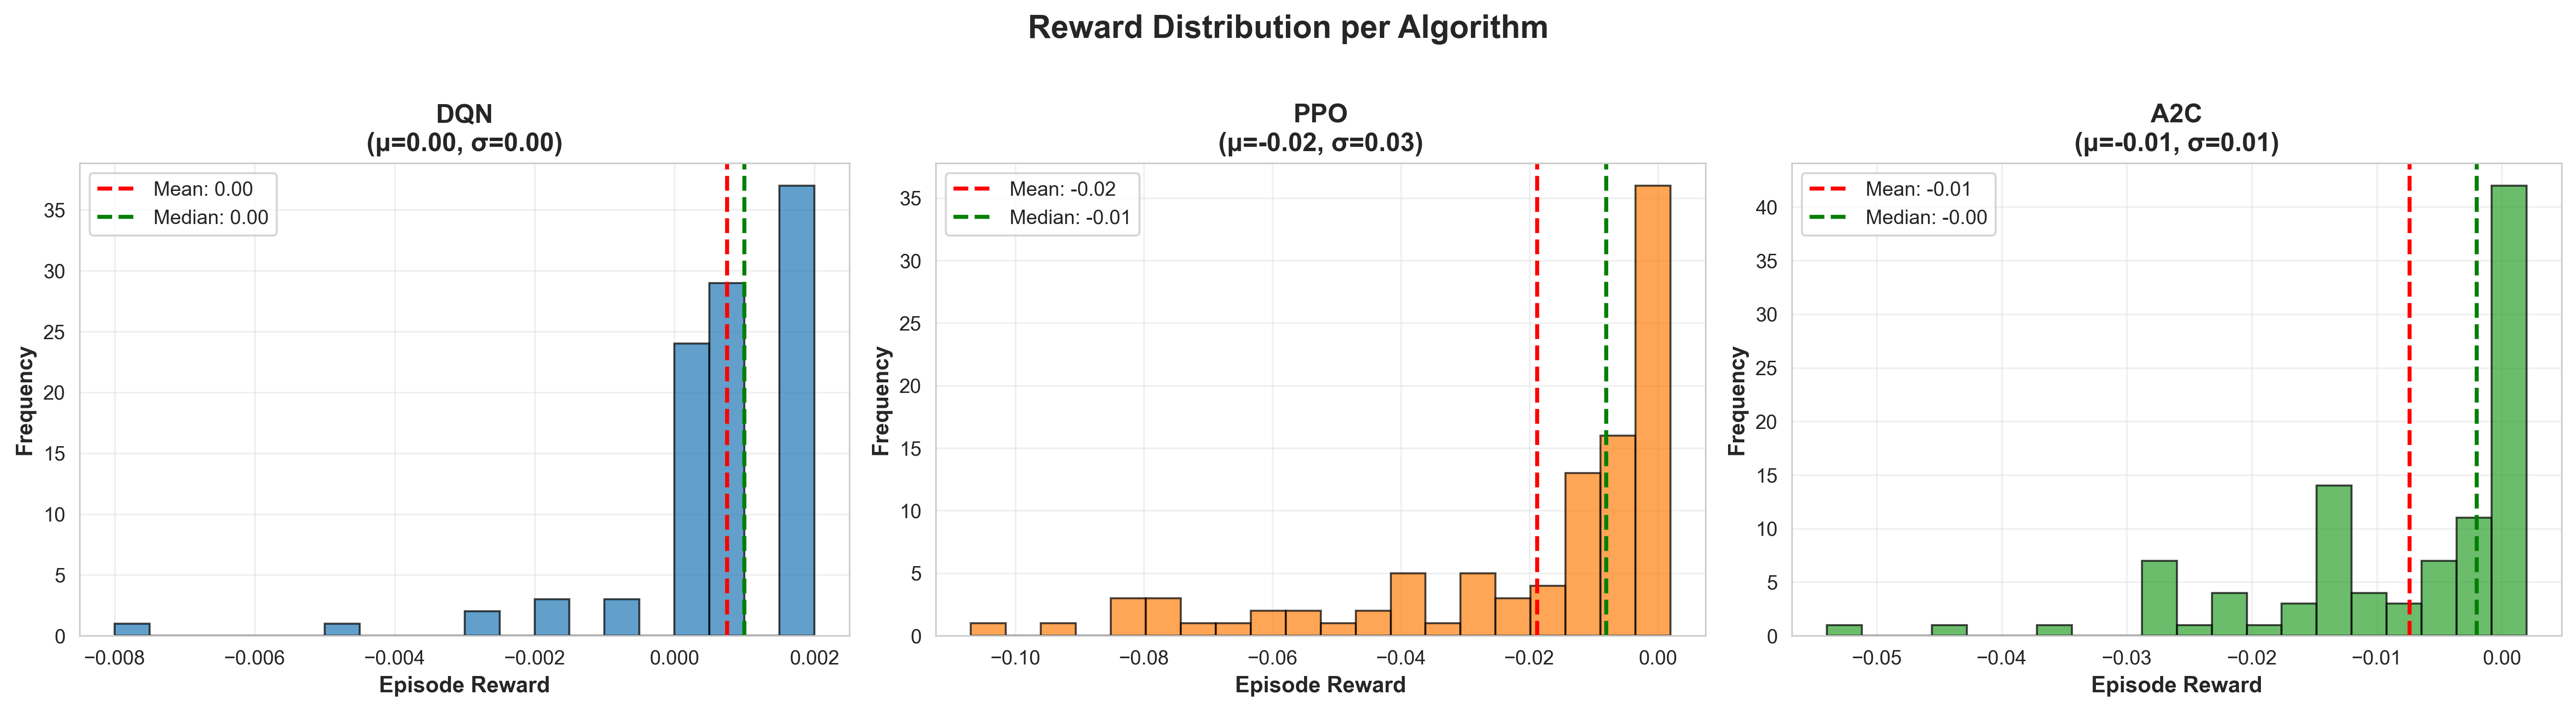


Custom Environment Learning Curves:


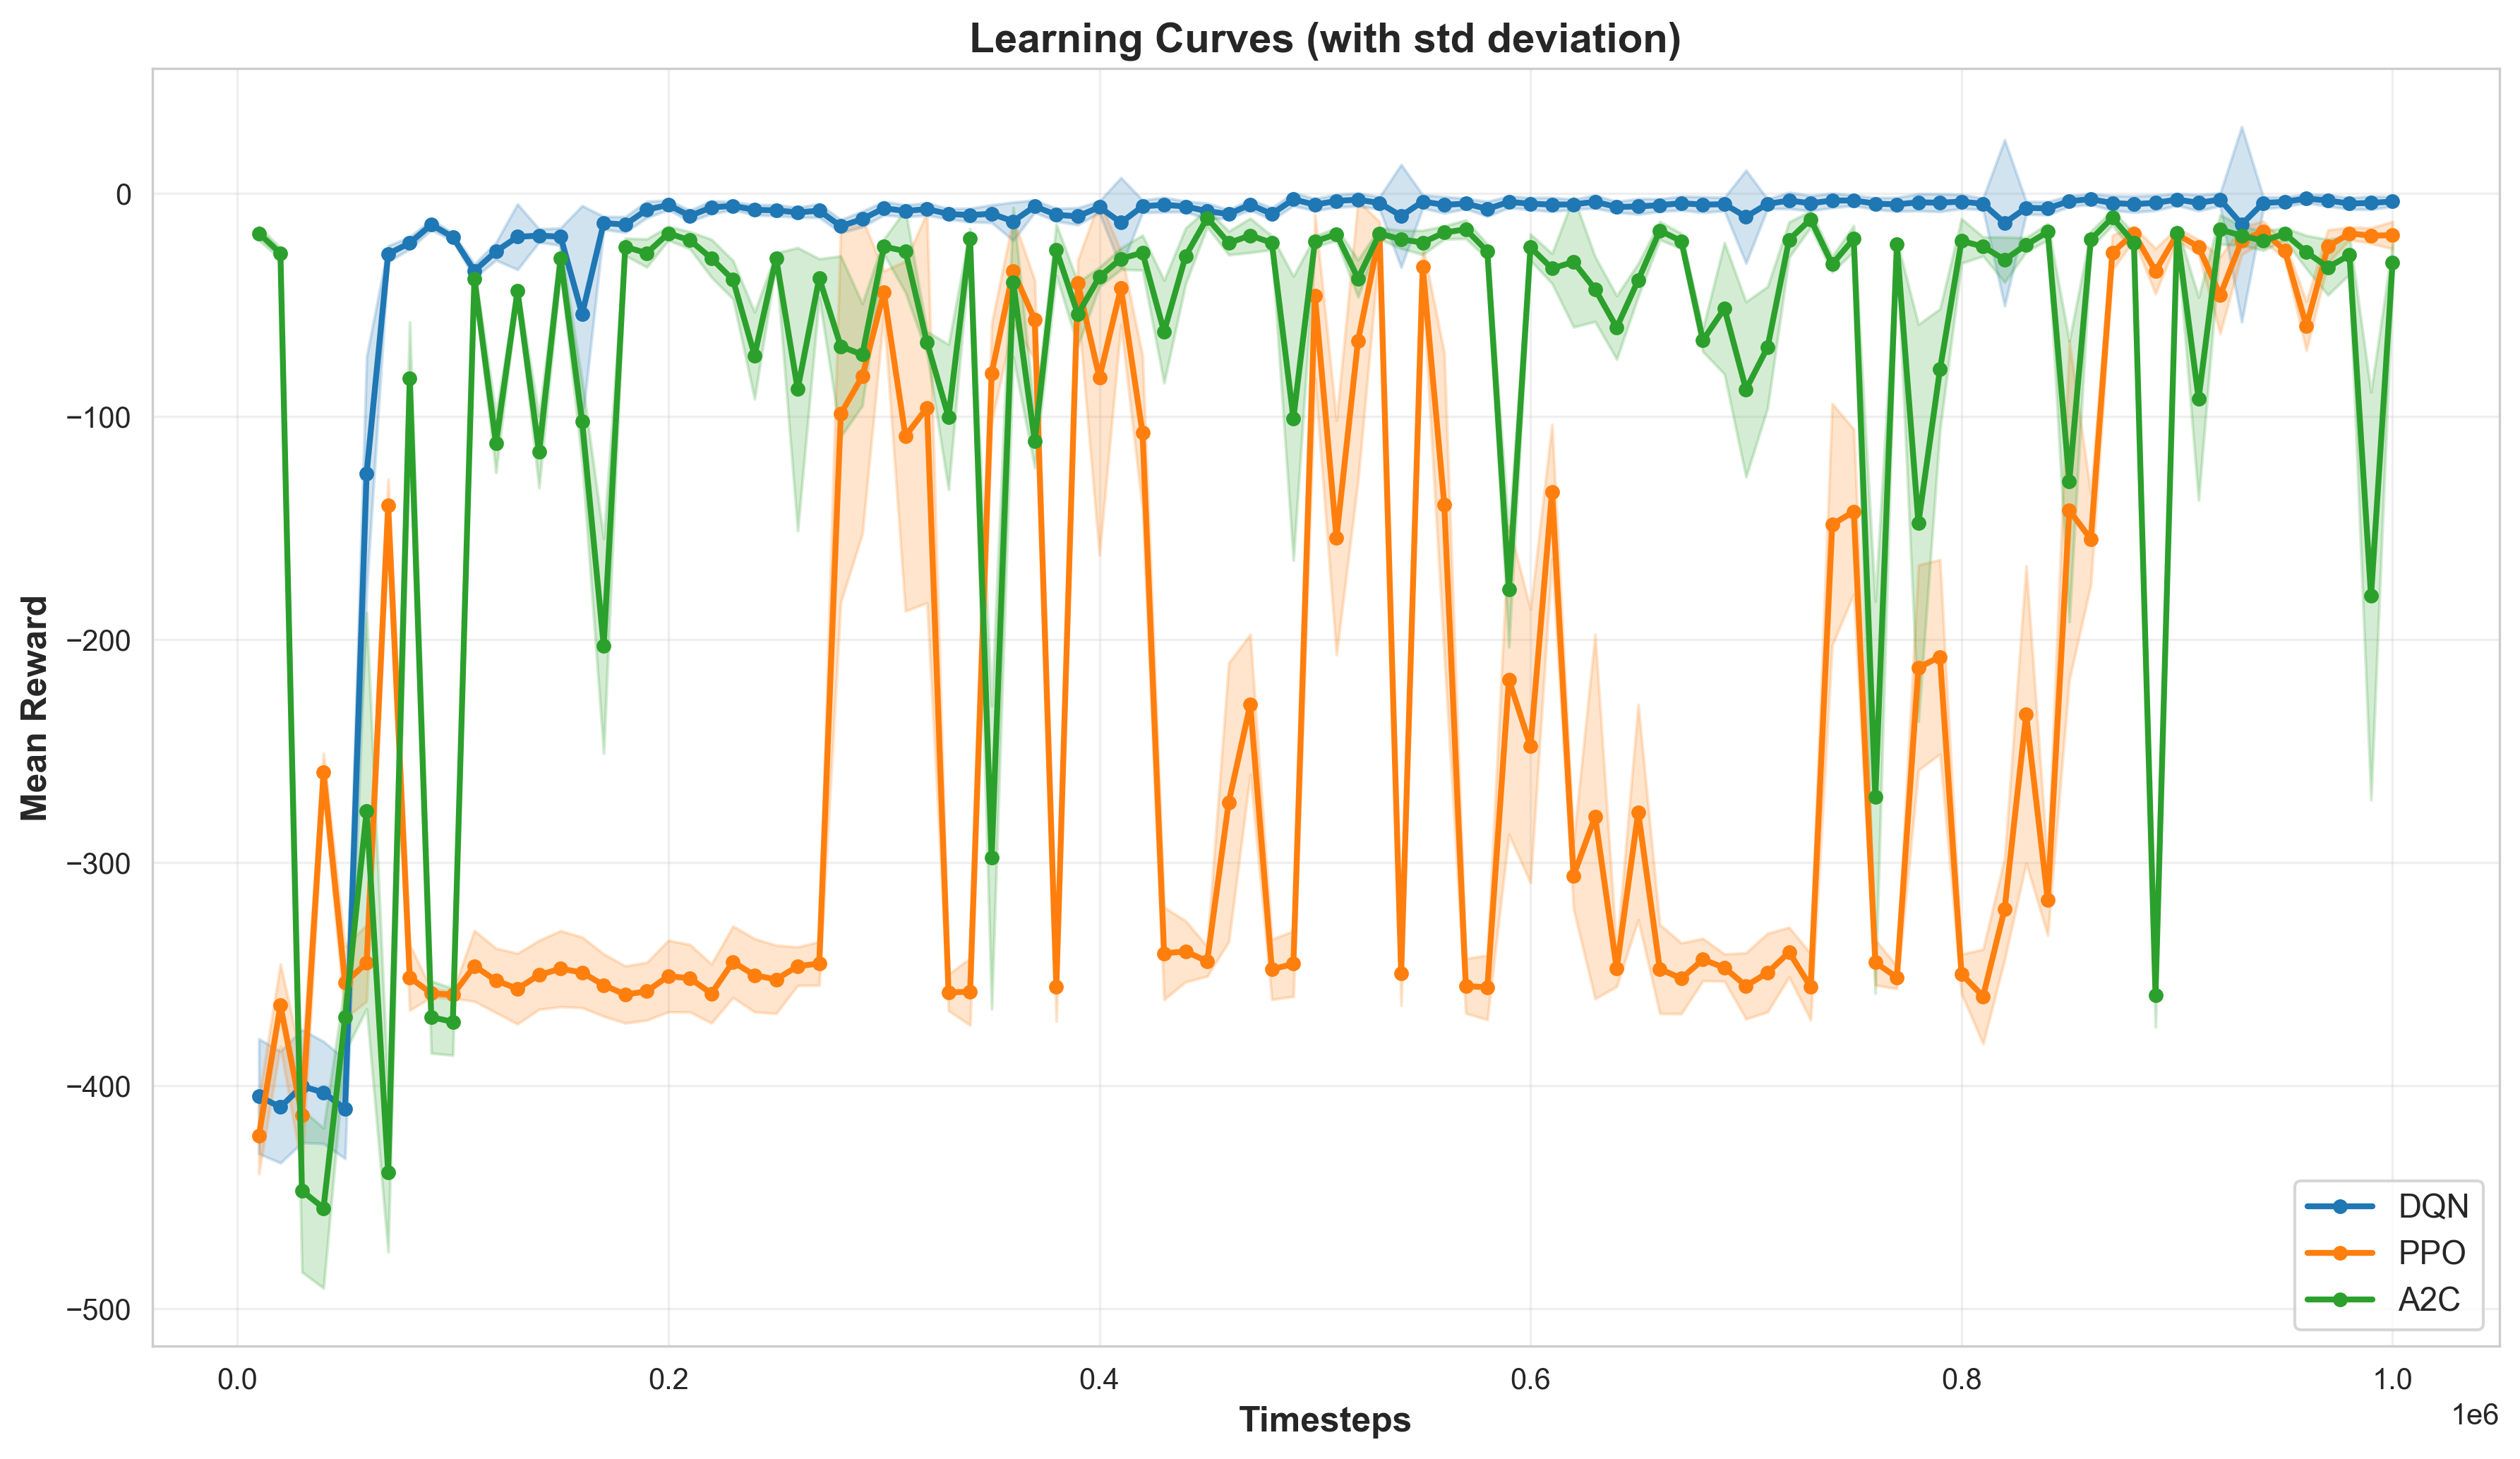

In [ ]:
print("\nCustom Environment Performance:")
display(Image('custom_1M/figures/custom_performance.png'))

print("\nCustom Environment Reward Distributions:")
display(Image('custom_1M/figures/custom_distributions.png'))

print("\nCustom Environment Learning Curves:")
display(Image('custom_1M/figures/custom_learning_curves.png'))

**Overall Performance in the Custom Environment**

The introduction of reward shaping significantly alters the performance landscape observed in the baseline setting.

The mean episode rewards obtained in the custom environment are:
- DQN:
0.001 ± 0.002
- PPO:
−0.02 ± 0.03
- A2C:
−0.01 ± 0.01

Although the absolute reward magnitudes are small due to the scaling of shaping terms, DQN emerges as the best-performing algorithm, achieving the highest mean and median episode reward and being the only algorithm with a consistently positive average return.
This represents a clear inversion of the baseline ranking, where PPO previously outperformed DQN and A2C under sparse rewards.

**Comparison with Baseline Results**

In the baseline environment:
- PPO achieved the highest mean reward (+1.44),
- DQN performed poorly (−2.05),
- A2C showed intermediate performance (−1.19).

After reward engineering:
DQN improves dramatically from strongly negative performance to near-zero and slightly positive returns.
PPO and A2C fail to leverage the shaped rewards effectively, resulting in slightly negative mean rewards.
This comparison demonstrates that reward shaping does not benefit all algorithms equally and that its effectiveness is strongly coupled to the learning paradigm.

**Distribution of Rewards**

DQN
- Extremely narrow reward distribution
- Median reward ≈ mean reward ≈ 0.001
- Very low variance (σ ≈ 0.0016)

This indicates that DQN converges to a stable and consistent policy, repeatedly achieving similar outcomes across evaluation episodes. The low variance suggests that the agent has learned to reliably exploit the shaped reward components.

PPO
- Wide reward distribution with long negative tails
- Mean reward = −0.02
- High variance relative to mean

The reward distribution reveals that PPO frequently triggers penalty-dominated trajectories, particularly repetition and fire-window penalties. Despite PPO’s strong performance in the sparse-reward baseline, its policy-gradient updates appear more sensitive to the dense penalty structure introduced by reward shaping.

A2C
- Moderate variance
- Mean reward slightly below zero
- Fewer extreme failures compared to PPO

A2C exhibits more controlled behavior than PPO but still fails to consistently accumulate positive shaped rewards, suggesting limited exploitation of the reward structure.

**Learning Curves and Training Stability**

The learning curves reveal distinct adaptation patterns:
- DQN shows rapid stabilization after an initial exploration phase, converging to near-zero mean reward with low variance.
- PPO exhibits highly unstable learning, with frequent large negative spikes throughout training.
- A2C demonstrates intermittent improvements but fails to converge to a stable regime.

These observations indicate that value-based methods are better suited to the introduced reward structure, which contains frequent, small-magnitude shaping signals and penalties.

**Analysis of Reward Components (Custom Statistics)**

The custom environment statistics provide further insight into algorithm behavior.

For DQN:
- High accumulation of movement bonuses and fire bonuses
- Relatively low repetition and fire-window penalties
- Positive reward delta (+0.776) between original and modified reward

This indicates that DQN successfully learns to optimize local reward components, balancing bonuses and penalties in a stable manner.

For PPO:
- Extremely high fire bonuses but also very high repetition penalties
- Net negative reward despite frequent action execution

This suggests that PPO over-explores action-heavy strategies, accumulating penalties faster than bonuses.

**Why DQN Performs Best in the Custom Environment**

The results suggest that the reward-engineered environment favors value-based learning:
- Dense, low-magnitude rewards align well with Q-value estimation.
- DQN can precisely learn long-term action-value trade-offs between bonuses and penalties.
- Experience replay stabilizes learning under noisy, frequent reward updates.
- PPO and A2C suffer from high-variance gradient updates amplified by dense penalties.

Thus, while PPO excels under sparse, goal-driven rewards, DQN is better suited to environments dominated by dense shaping terms.

***
## 6. Evaluation and Comparison

### 6.1 Methodology

All algorithms were trained for 1 million timesteps under two experimental conditions:
- Baseline environment: original IceHockey-v5 with sparse goal-based rewards.
- Custom environment: IceHockey-v5 augmented with dense reward shaping components.

To ensure a fair comparison:
- identical network architectures and observation preprocessing were used,
- hyperparameters remained unchanged between conditions,
- each trained model was evaluated over 100 independent episodes,
- evaluation metrics were computed using deterministic policies.

This controlled setup allows performance differences to be attributed directly to the environment modifications.

### 6.2 Quantitative Results

**Mean Episode Reward (Before vs After)**

| Algorithm | Baseline Mean ± Std | Custom Mean ± Std | Δ Performance |
|:---------|---------------------:|------------------:|:-------------|
| DQN      | −2.05 ± 2.23        | +0.001 ± 0.002   | ↑ Strong improvement |
| PPO      | +1.44 ± 3.46        | −0.02 ± 0.03     | ↓ Performance drop |
| A2C     | −1.19 ± 2.94        | −0.01 ± 0.01     | ↑ Moderate improvement |


Observations:

- DQN shows the largest improvement, moving from clearly negative to slightly positive performance.
- PPO experiences a significant performance degradation after reward shaping.
- A2C improves relative to baseline but does not surpass zero mean reward.

### 6.3 Qualitative Results

Behavioral Comparison

Baseline environment:
- DQN exhibits random movement and ineffective shooting.
- PPO displays more structured offensive behavior.
- A2C shows inconsistent positioning and frequent puck loss.

Custom environment:
- DQN learns stable, low-variance policies that consistently exploit shaped rewards.
- PPO exhibits excessive action repetition, triggering penalty-heavy trajectories.
- A2C demonstrates improved positioning but limited reward optimization.

These observations indicate that reward shaping promotes behavioral consistency in DQN, while inducing overactive policies in PPO.

### 6.4 Learning curve analysis

Before Modification
- PPO shows the fastest learning and best convergence.
- DQN and A2C struggle with sparse rewards and exhibit slow improvement.

After Modification
- DQN converges rapidly to a stable performance regime.
- PPO displays highly unstable learning curves with frequent negative spikes.
- A2C improves stability but fails to fully converge.

This highlights a fundamental shift in learning dynamics caused by reward engineering.

### 6.5 Visualizations

The following visualizations support the quantitative and qualitative findings:
- Mean episode reward bar charts (baseline vs custom)
- Reward distributions (violin and box plots)
- Learning curves with standard deviation
- Episode length comparisons

These figures clearly illustrate the ranking inversion between algorithms, with DQN outperforming PPO in the custom environment.

### Summary:

- Before modification: PPO > A2C > DQN
- After modification: DQN > A2C > PPO

This inversion demonstrates that algorithm performance is highly sensitive to reward design. Value-based methods benefit from dense shaping, while policy-gradient methods perform better under sparse, goal-driven objectives.

In [4]:
class VideoConfig:
    """Configuration for video recording"""

    BASELINE_DIR = "baseline_1M/"
    CUSTOM_DIR = "custom_1M/"
    VIDEO_DIR = "videos/"

    VIDEO_LENGTH = 2000  # steps per video
    FPS = 30

    @classmethod
    def create_dirs(cls):
        os.makedirs(cls.VIDEO_DIR, exist_ok=True)
        os.makedirs(os.path.join(cls.VIDEO_DIR, "random"), exist_ok=True)
        os.makedirs(os.path.join(cls.VIDEO_DIR, "baseline"), exist_ok=True)
        os.makedirs(os.path.join(cls.VIDEO_DIR, "custom"), exist_ok=True)

def display_videos():
    """
    Display recorded videos in Jupyter notebook
    """

    categories = ["random", "baseline", "custom"]

    for category in categories:
        video_folder = os.path.join(VideoConfig.VIDEO_DIR, category)
        video_files = glob.glob(os.path.join(video_folder, "*.mp4"))

        print(f"\n{category.upper()}:")
        for video_file in sorted(video_files):
            display(Video(video_file, width=600))

In [5]:
display_videos()


RANDOM:



BASELINE:



CUSTOM:


***
## 7. Discussion

This work investigated the impact of reward engineering on reinforcement learning performance in the IceHockey-v5 environment. While the results demonstrate that modifying the reward structure can significantly influence learning dynamics and algorithm performance, several limitations were identified during development.

A key limitation was the restricted scope for feature engineering imposed by the Gymnasium Atari interface. The environment provides mainly raw pixel observations, without direct access to high-level semantic information such as puck possession, precise positions, or velocities. As a result, reward shaping had to rely on indirect or proxy signals, limiting the precision of the engineered rewards.

The use of computer vision techniques to extract higher-level features from visual observations was considered. However, this approach was deliberately not pursued, as it would have shifted the focus of the project toward perception and visual processing rather than reinforcement learning itself. Since the main objective of this work was to study the effects of reward engineering, maintaining a simple observation pipeline allowed for a clearer isolation of the reward design impact.

Overall, the results highlight that reward engineering alone can substantially alter learning behavior, but also emphasize that its effectiveness is constrained by the level of state information available. These findings reinforce the importance of aligning environment design choices with the specific research goals of a reinforcement learning study.

***
## 8. Conclusion

This project explored the impact of environment customization through reward engineering on reinforcement learning performance in the IceHockey-v5 environment. By systematically comparing three different algorithms — DQN, PPO, and A2C — under both the original sparse-reward setting and a modified dense-reward environment, this work demonstrated that reward design plays a critical role in shaping learning outcomes.

The experimental results showed that algorithm performance is highly sensitive to the reward structure. While PPO achieved the best results in the baseline environment, the introduction of dense shaping rewards led to a clear shift in performance, with DQN emerging as the most effective algorithm in the custom environment. This inversion highlights the strong coupling between learning paradigms and reward characteristics, emphasizing that no single algorithm is universally optimal across reward formulations.

Additionally, the study confirmed that reward engineering can significantly improve learning stability and convergence, even without altering the observation space or introducing additional state information. At the same time, the observed limitations underscore that reward shaping alone cannot fully compensate for restricted access to high-level environment features.

Overall, this work reinforces the importance of careful environment and reward design in reinforcement learning and demonstrates that meaningful performance improvements can be achieved through targeted environment modifications. The findings provide practical insights into how reward engineering influences different reinforcement learning algorithms and offer a solid foundation for future work exploring richer state representations or more advanced environment customizations.

***
## 9. References

[1] Song, Y. et al. (2023). The Role of a Reward in Shaping Multiple Football Agents’ Behavior. <br>
[2] Zhang, H. et al. (2023). Embedding Contextual Information through Reward Shaping in Multi-Agent Learning. <br>
[3] Martins, F. B. et al. (2021). rSoccer: A Framework for Studying Reinforcement Learning. <br>
[4] Song, Y. et al. (2024). Boosting Studies of Multi-Agent RL on Google Research Football.